#Introduction

Implementing K-fold cross validation, with scikit-learn.
In order to build this notebook, we started from "Attention_win90st5_128LSTM" and we implemented the k-fold cross validation, with $K=8$. In this case we generate one model per each sample. By printing the metrics then, we are able to select the best one between them.


References:


*   https://www.machinecurve.com/index.php/2020/02/18/how-to-use-k-fold-cross-validation-with-keras/
*   https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
*   https://scikit-learn.org/stable/auto_examples/exercises/plot_cv_diabetes.html#sphx-glr-auto-examples-exercises-plot-cv-diabetes-py




# Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
%cd /gdrive/MyDrive/Documenti/Università/Magistrale/SecondoAnno/PrimoSemestre/AN2DL/Challenge2

/gdrive/MyDrive/Documenti/Università/Magistrale/SecondoAnno/PrimoSemestre/AN2DL/Challenge2


In [ ]:
!pip install keras-self-attention

  Created wheel for keras-self-attention: filename=keras_self_attention-0.50.0-py3-none-any.whl size=19414 sha256=0d040ad36620aef4e298f2d96311a6a8e978f93efebedccad8dd306848d9db58
  Stored in directory: /root/.cache/pip/wheels/92/7a/a3/231bef5803298e7ec1815215bc0613239cb1e9c03c57b13c14
Successfully built keras-self-attention


# Import libraries

In [ ]:
title = 'Attention_win90st5_128LSTM_kfold' #used to save models and checkpoint. Assumes in the current folder, you have a folder called "Models"

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
import warnings
from keras_self_attention import SeqSelfAttention, SeqWeightedAttention

warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


### Set seed for reproducibility

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Exploration Data Analysis (EDA)


Load the dataset

In [ ]:
dataset = pd.read_csv('Dataset/Training.csv')
print(dataset.shape)
dataset.head()

(68528, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
2,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
3,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
4,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68528 entries, 0 to 68527
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sponginess          68528 non-null  float64
 1   Wonder level        68528 non-null  float64
 2   Crunchiness         68528 non-null  float64
 3   Loudness on impact  68528 non-null  float64
 4   Meme creativity     68528 non-null  float64
 5   Soap slipperiness   68528 non-null  float64
 6   Hype root           68528 non-null  float64
dtypes: float64(7)
memory usage: 3.7 MB


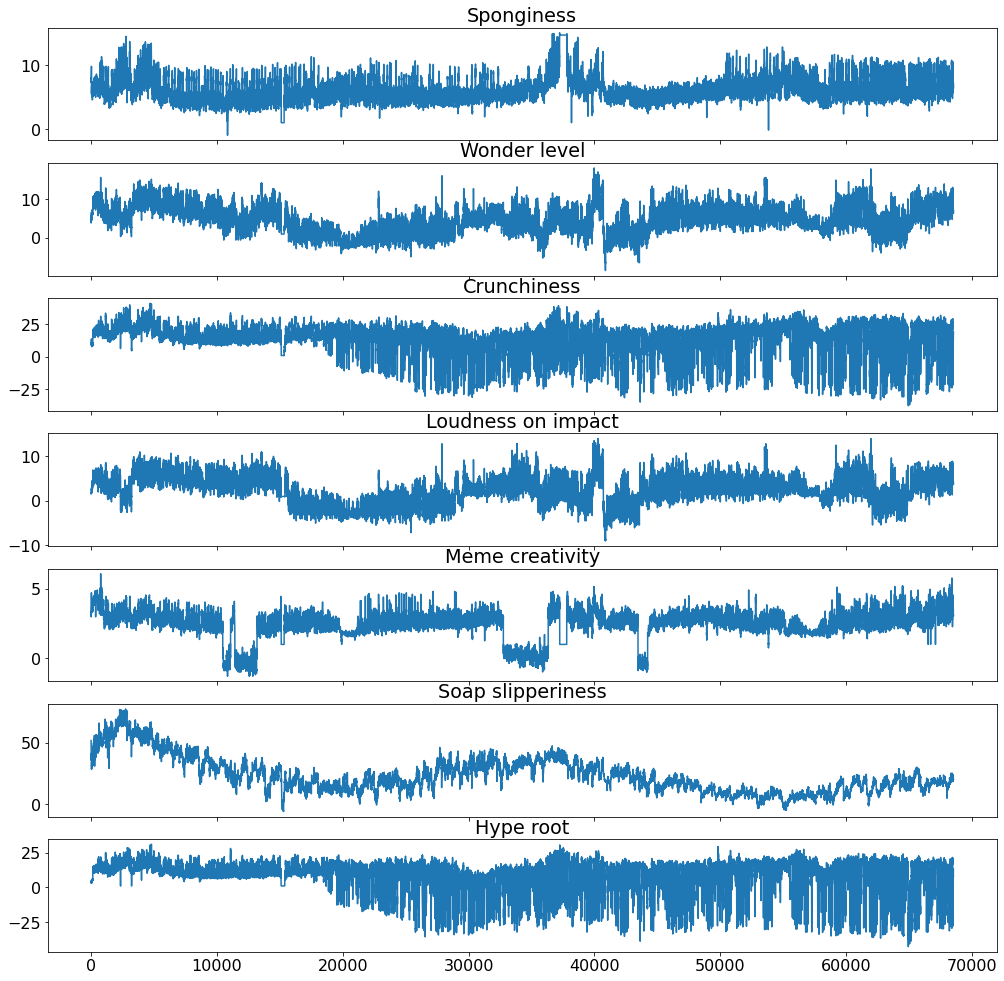

In [ ]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
inspect_dataframe(dataset, dataset.columns)

Sequential Train-Test split and normalization

In [ ]:
print((dataset.shape))

(68528, 7)


In [ ]:
X_train_raw = dataset.iloc[:]

# Normalize both features and labels
X_min = X_train_raw.min()
X_max = X_train_raw.max()

X_train_raw = (X_train_raw-X_min)/(X_max-X_min)

In [ ]:
print('X_min')
print(X_min)
print('X_max')
print(X_max)

X_min
Sponginess            -0.972080
Wonder level          -8.450380
Crunchiness          -37.581721
Loudness on impact    -9.028060
Meme creativity       -1.275860
Soap slipperiness     -6.006860
Hype root            -42.769221
dtype: float64
X_max
Sponginess            15.106680
Wonder level          18.122899
Crunchiness           41.138801
Loudness on impact    14.035980
Meme creativity        6.056360
Soap slipperiness     77.371620
Hype root             31.024420
dtype: float64


In [ ]:
direct_window = 90
direct_stride = 5
ar_window = 90
ar_stride = 5
general_telescope = 864

In [ ]:
future = dataset[-direct_window:]
future = (future-X_min)/(X_max-X_min)
future = np.expand_dims(future, axis=0)
print(future.shape)

(1, 90, 7)


In [ ]:
def build_sequences(df, target_labels=['Sponginess'], window=200, stride=20, telescope=864):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

# Utility functions

In [ ]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('Check')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback  = tfk.callbacks.EarlyStopping(monitor='val_rmse', mode='min', patience=30, restore_best_weights=True),
  callbacks.append(es_callback)
  es2_callback = tfk.callbacks.ReduceLROnPlateau(monitor='val_rmse', mode='min', patience=5, factor=0.5, min_lr=1e-5)
  callbacks.append(es2_callback)

  return callbacks

In [ ]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

In [ ]:
def build_LSTM_model(input_shape, output_shape):
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    lstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(input_layer)
    print(lstm.shape)
    attention = SeqSelfAttention(attention_activation='sigmoid')(lstm)
    print(attention.shape)
    gap = tfkl.GlobalAveragePooling1D()(attention)
    dense = tfkl.Dense(output_shape[0]*output_shape[1], activation='relu')(gap)
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)
    # Connect input and output through the Model class
    full_model = tfk.Model(inputs=input_layer, outputs=output_layer)
    # Compile the model
    full_model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')])

    # Return the model
    return full_model

# Forecasting

In [ ]:
target_labels = dataset.columns
telescope = 864

In [ ]:
X_train, y_train = build_sequences(X_train_raw, target_labels, ar_window, ar_stride, telescope)
X_train.shape, y_train.shape

((13526, 90, 7), (13526, 864, 7))

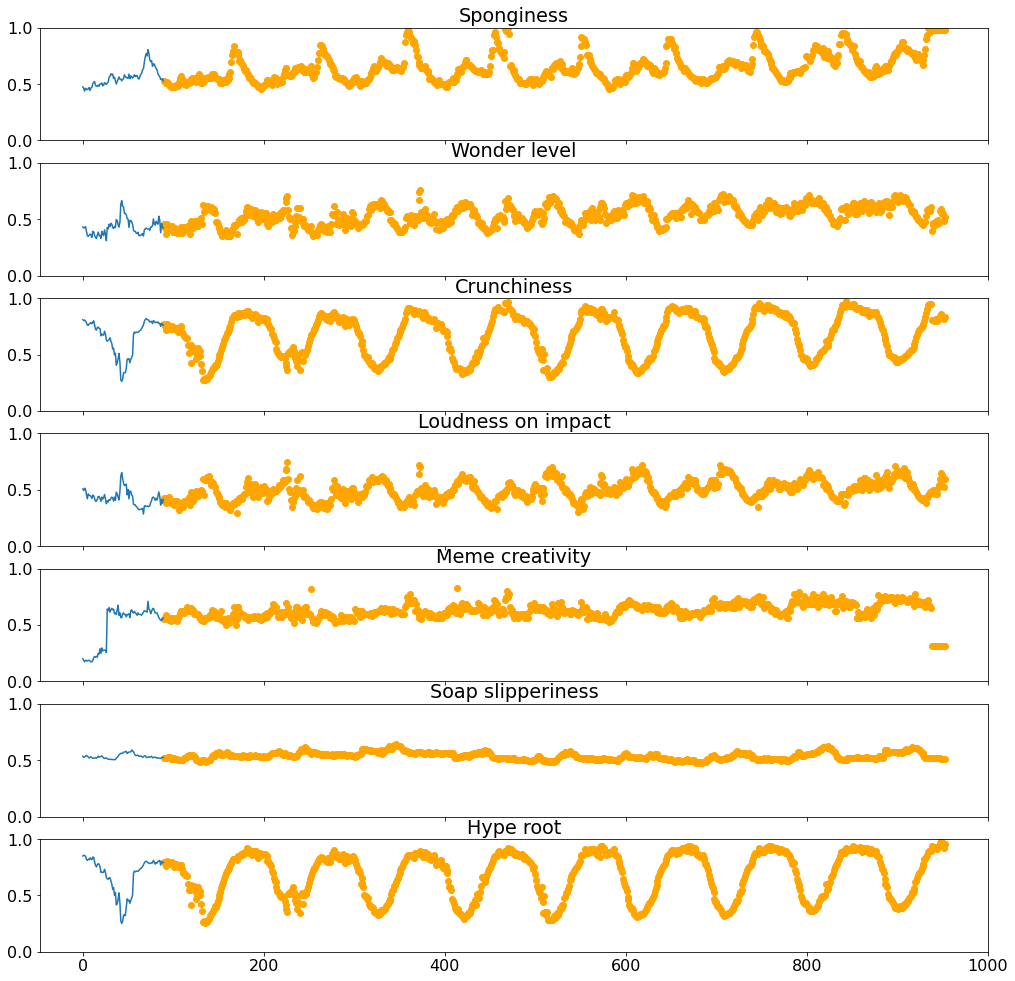

In [ ]:
inspect_multivariate(X_train, y_train, target_labels, telescope)

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 8
epochs = 500
num_folds = 8 # number of folds for K-fold

# we will have num_folds models
models = []

# needed to save scores
val_rmses = []

In [ ]:
print(input_shape, output_shape)

(90, 7) (864, 7)


Define the K-fold Cross validator

In [ ]:
kfold = KFold(n_splits=num_folds) #can be set a shuffle parameter (see documentation)

#Training and testing

Train with K-fold

In [ ]:
fold_no = 0
for train, test in kfold.split(X_train, y_train):

  # Define the model architecture
  model = build_LSTM_model(input_shape, output_shape)
  # model.summary()  # commented to avoid too much prints
  # tfk.utils.plot_model(model, expand_nested=True) # commented to avoid too much prints

  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  # Create folders and callbacks and fit
  # Fit data to model
  cbs = create_folders_and_callbacks(model_name = title) #the model name will generate the folder of this single experiment

  # restore checkpoints:
  # model.load_weights('/gdrive/MyDrive/Documenti/Università/Magistrale/SecondoAnno/PrimoSemestre/AN2DL/Challenge2/Check/+'title'+_datetime/ckpts/cp.ckpt') #for this, I've looked at: https://www.tensorflow.org/tutorials/keras/save_and_load
  # In this way, the training will restart from that specific checkpoint: clearly, Epoch number will restart from zero, but that's not a problem, it's restarting from the weights computed at ckpt

  # Train the model
  history = model.fit(
    x = X_train[train],
    y = y_train[train],
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = cbs
  ).history

  # appending generated model
  models.append(model)

  # Saving generated model. Useful to be done here, otherwise, if colab stops you, you loose already generated ones
  model.save('Models/'+title+'_fold_nmbr_'+str(fold_no))

  # Storing metrics:
  scores = model.evaluate(X_train[test], y_train[test]) # evaluate on the selected fold
  print(scores)
  val_rmses.append(scores[2])

  # Increase fold number
  fold_no = fold_no + 1


(None, 90, 256)
(None, 90, 256)
------------------------------------------------------------------------
Training for fold 0 ...
Epoch 1/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0584 - mae: 0.1559 - rmse: 0.2416

1332/1332 [==============================] - 36s 23ms/step - loss: 0.0583 - mae: 0.1559 - rmse: 0.2416 - val_loss: 0.0322 - val_mae: 0.1211 - val_rmse: 0.1794 - lr: 0.0010
Epoch 2/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0202 - mae: 0.0897 - rmse: 0.1420

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0202 - mae: 0.0897 - rmse: 0.1420 - val_loss: 0.0218 - val_mae: 0.0991 - val_rmse: 0.1475 - lr: 0.0010
Epoch 3/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0162 - mae: 0.0807 - rmse: 0.1275

1332/1332 [==============================] - 30s 22ms/step - loss: 0.0162 - mae: 0.0807 - rmse: 0.1274 - val_loss: 0.0180 - val_mae: 0.0902 - val_rmse: 0.1341 - lr: 0.0010
Epoch 4/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0136 - mae: 0.0750 - rmse: 0.1167

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0136 - mae: 0.0750 - rmse: 0.1167 - val_loss: 0.0159 - val_mae: 0.0869 - val_rmse: 0.1260 - lr: 0.0010
Epoch 5/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0115 - mae: 0.0704 - rmse: 0.1074

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0115 - mae: 0.0704 - rmse: 0.1074 - val_loss: 0.0132 - val_mae: 0.0787 - val_rmse: 0.1147 - lr: 0.0010
Epoch 6/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0099 - mae: 0.0667 - rmse: 0.0993

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0099 - mae: 0.0667 - rmse: 0.0993 - val_loss: 0.0125 - val_mae: 0.0807 - val_rmse: 0.1117 - lr: 0.0010
Epoch 7/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0088 - mae: 0.0642 - rmse: 0.0937

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0088 - mae: 0.0642 - rmse: 0.0937 - val_loss: 0.0116 - val_mae: 0.0775 - val_rmse: 0.1079 - lr: 0.0010
Epoch 8/500
1328/1332 [============================>.] - ETA: 0s - loss: 0.0079 - mae: 0.0620 - rmse: 0.0891

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0079 - mae: 0.0620 - rmse: 0.0891 - val_loss: 0.0115 - val_mae: 0.0786 - val_rmse: 0.1075 - lr: 0.0010
Epoch 9/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0075 - mae: 0.0608 - rmse: 0.0868

1332/1332 [==============================] - 29s 21ms/step - loss: 0.0075 - mae: 0.0608 - rmse: 0.0868 - val_loss: 0.0107 - val_mae: 0.0761 - val_rmse: 0.1032 - lr: 0.0010
Epoch 10/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0072 - mae: 0.0598 - rmse: 0.0848

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0072 - mae: 0.0598 - rmse: 0.0848 - val_loss: 0.0103 - val_mae: 0.0739 - val_rmse: 0.1015 - lr: 0.0010
Epoch 11/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0069 - mae: 0.0590 - rmse: 0.0833

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0069 - mae: 0.0590 - rmse: 0.0834 - val_loss: 0.0105 - val_mae: 0.0749 - val_rmse: 0.1023 - lr: 0.0010
Epoch 12/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0068 - mae: 0.0582 - rmse: 0.0823

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0068 - mae: 0.0582 - rmse: 0.0823 - val_loss: 0.0102 - val_mae: 0.0749 - val_rmse: 0.1012 - lr: 0.0010
Epoch 13/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0066 - mae: 0.0577 - rmse: 0.0815

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0066 - mae: 0.0577 - rmse: 0.0815 - val_loss: 0.0101 - val_mae: 0.0746 - val_rmse: 0.1007 - lr: 0.0010
Epoch 14/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0064 - mae: 0.0571 - rmse: 0.0803

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0064 - mae: 0.0571 - rmse: 0.0803 - val_loss: 0.0106 - val_mae: 0.0763 - val_rmse: 0.1031 - lr: 0.0010
Epoch 15/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0063 - mae: 0.0562 - rmse: 0.0792

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0063 - mae: 0.0562 - rmse: 0.0792 - val_loss: 0.0108 - val_mae: 0.0761 - val_rmse: 0.1038 - lr: 0.0010
Epoch 16/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0061 - mae: 0.0557 - rmse: 0.0784

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0061 - mae: 0.0557 - rmse: 0.0784 - val_loss: 0.0104 - val_mae: 0.0748 - val_rmse: 0.1017 - lr: 0.0010
Epoch 17/500
1328/1332 [============================>.] - ETA: 0s - loss: 0.0060 - mae: 0.0553 - rmse: 0.0776

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0060 - mae: 0.0553 - rmse: 0.0776 - val_loss: 0.0106 - val_mae: 0.0757 - val_rmse: 0.1030 - lr: 0.0010
Epoch 18/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0059 - mae: 0.0546 - rmse: 0.0767

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0059 - mae: 0.0546 - rmse: 0.0767 - val_loss: 0.0104 - val_mae: 0.0748 - val_rmse: 0.1019 - lr: 0.0010
Epoch 19/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0054 - mae: 0.0522 - rmse: 0.0734

1332/1332 [==============================] - 30s 22ms/step - loss: 0.0054 - mae: 0.0522 - rmse: 0.0734 - val_loss: 0.0105 - val_mae: 0.0748 - val_rmse: 0.1025 - lr: 5.0000e-04
Epoch 20/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0052 - mae: 0.0516 - rmse: 0.0723

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0052 - mae: 0.0516 - rmse: 0.0723 - val_loss: 0.0108 - val_mae: 0.0765 - val_rmse: 0.1039 - lr: 5.0000e-04
Epoch 21/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0052 - mae: 0.0513 - rmse: 0.0718

1332/1332 [==============================] - 30s 22ms/step - loss: 0.0052 - mae: 0.0513 - rmse: 0.0718 - val_loss: 0.0104 - val_mae: 0.0756 - val_rmse: 0.1020 - lr: 5.0000e-04
Epoch 22/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0052 - mae: 0.0513 - rmse: 0.0718

1332/1332 [==============================] - 30s 22ms/step - loss: 0.0052 - mae: 0.0513 - rmse: 0.0718 - val_loss: 0.0102 - val_mae: 0.0745 - val_rmse: 0.1010 - lr: 5.0000e-04
Epoch 23/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0051 - mae: 0.0510 - rmse: 0.0714

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0051 - mae: 0.0510 - rmse: 0.0714 - val_loss: 0.0107 - val_mae: 0.0761 - val_rmse: 0.1036 - lr: 5.0000e-04
Epoch 24/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0048 - mae: 0.0495 - rmse: 0.0693

1332/1332 [==============================] - 30s 22ms/step - loss: 0.0048 - mae: 0.0495 - rmse: 0.0693 - val_loss: 0.0107 - val_mae: 0.0761 - val_rmse: 0.1036 - lr: 2.5000e-04
Epoch 25/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0048 - mae: 0.0493 - rmse: 0.0691

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0048 - mae: 0.0493 - rmse: 0.0691 - val_loss: 0.0107 - val_mae: 0.0757 - val_rmse: 0.1033 - lr: 2.5000e-04
Epoch 26/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0047 - mae: 0.0490 - rmse: 0.0686

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0047 - mae: 0.0490 - rmse: 0.0686 - val_loss: 0.0107 - val_mae: 0.0764 - val_rmse: 0.1035 - lr: 2.5000e-04
Epoch 27/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0047 - mae: 0.0489 - rmse: 0.0684

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0047 - mae: 0.0489 - rmse: 0.0684 - val_loss: 0.0110 - val_mae: 0.0774 - val_rmse: 0.1047 - lr: 2.5000e-04
Epoch 28/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0046 - mae: 0.0487 - rmse: 0.0681

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0046 - mae: 0.0487 - rmse: 0.0681 - val_loss: 0.0108 - val_mae: 0.0766 - val_rmse: 0.1038 - lr: 2.5000e-04
Epoch 29/500
1328/1332 [============================>.] - ETA: 0s - loss: 0.0045 - mae: 0.0480 - rmse: 0.0672

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0045 - mae: 0.0481 - rmse: 0.0672 - val_loss: 0.0108 - val_mae: 0.0767 - val_rmse: 0.1040 - lr: 1.2500e-04
Epoch 30/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0045 - mae: 0.0479 - rmse: 0.0670

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0045 - mae: 0.0479 - rmse: 0.0670 - val_loss: 0.0111 - val_mae: 0.0777 - val_rmse: 0.1053 - lr: 1.2500e-04
Epoch 31/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0045 - mae: 0.0478 - rmse: 0.0669

1332/1332 [==============================] - 30s 22ms/step - loss: 0.0045 - mae: 0.0478 - rmse: 0.0669 - val_loss: 0.0109 - val_mae: 0.0768 - val_rmse: 0.1042 - lr: 1.2500e-04
Epoch 32/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0045 - mae: 0.0477 - rmse: 0.0668

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0045 - mae: 0.0477 - rmse: 0.0668 - val_loss: 0.0108 - val_mae: 0.0767 - val_rmse: 0.1041 - lr: 1.2500e-04
Epoch 33/500
1328/1332 [============================>.] - ETA: 0s - loss: 0.0044 - mae: 0.0476 - rmse: 0.0665

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0044 - mae: 0.0476 - rmse: 0.0665 - val_loss: 0.0108 - val_mae: 0.0764 - val_rmse: 0.1039 - lr: 1.2500e-04
Epoch 34/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0044 - mae: 0.0473 - rmse: 0.0662

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0044 - mae: 0.0473 - rmse: 0.0662 - val_loss: 0.0109 - val_mae: 0.0771 - val_rmse: 0.1046 - lr: 6.2500e-05
Epoch 35/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0044 - mae: 0.0472 - rmse: 0.0660

1332/1332 [==============================] - 30s 22ms/step - loss: 0.0044 - mae: 0.0472 - rmse: 0.0661 - val_loss: 0.0109 - val_mae: 0.0767 - val_rmse: 0.1045 - lr: 6.2500e-05
Epoch 36/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0044 - mae: 0.0472 - rmse: 0.0660

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0044 - mae: 0.0472 - rmse: 0.0660 - val_loss: 0.0109 - val_mae: 0.0767 - val_rmse: 0.1044 - lr: 6.2500e-05
Epoch 37/500
1328/1332 [============================>.] - ETA: 0s - loss: 0.0043 - mae: 0.0471 - rmse: 0.0659

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0043 - mae: 0.0471 - rmse: 0.0659 - val_loss: 0.0110 - val_mae: 0.0773 - val_rmse: 0.1050 - lr: 6.2500e-05
Epoch 38/500
1328/1332 [============================>.] - ETA: 0s - loss: 0.0043 - mae: 0.0471 - rmse: 0.0658

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0043 - mae: 0.0471 - rmse: 0.0658 - val_loss: 0.0110 - val_mae: 0.0770 - val_rmse: 0.1047 - lr: 6.2500e-05
Epoch 39/500
1328/1332 [============================>.] - ETA: 0s - loss: 0.0043 - mae: 0.0469 - rmse: 0.0656

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0043 - mae: 0.0469 - rmse: 0.0656 - val_loss: 0.0110 - val_mae: 0.0773 - val_rmse: 0.1050 - lr: 3.1250e-05
Epoch 40/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0043 - mae: 0.0469 - rmse: 0.0656

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0043 - mae: 0.0469 - rmse: 0.0656 - val_loss: 0.0109 - val_mae: 0.0769 - val_rmse: 0.1046 - lr: 3.1250e-05
Epoch 41/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0043 - mae: 0.0469 - rmse: 0.0655

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0043 - mae: 0.0469 - rmse: 0.0655 - val_loss: 0.0110 - val_mae: 0.0772 - val_rmse: 0.1050 - lr: 3.1250e-05
Epoch 42/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0043 - mae: 0.0468 - rmse: 0.0655

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0043 - mae: 0.0468 - rmse: 0.0655 - val_loss: 0.0110 - val_mae: 0.0772 - val_rmse: 0.1050 - lr: 3.1250e-05
Epoch 43/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0043 - mae: 0.0468 - rmse: 0.0654

1332/1332 [==============================] - 30s 22ms/step - loss: 0.0043 - mae: 0.0468 - rmse: 0.0654 - val_loss: 0.0110 - val_mae: 0.0773 - val_rmse: 0.1050 - lr: 3.1250e-05


53/53 [==============================] - 1s 8ms/step - loss: 0.0189 - mae: 0.1018 - rmse: 0.1375
[0.01889747753739357, 0.10182388871908188, 0.13746808469295502]
(None, 90, 256)
(None, 90, 256)
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0591 - mae: 0.1538 - rmse: 0.2430

1332/1332 [==============================] - 32s 22ms/step - loss: 0.0590 - mae: 0.1537 - rmse: 0.2429 - val_loss: 0.0280 - val_mae: 0.1084 - val_rmse: 0.1672 - lr: 0.0010
Epoch 2/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0215 - mae: 0.0898 - rmse: 0.1468

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0215 - mae: 0.0898 - rmse: 0.1468 - val_loss: 0.0226 - val_mae: 0.1001 - val_rmse: 0.1505 - lr: 0.0010
Epoch 3/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0171 - mae: 0.0805 - rmse: 0.1310

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0171 - mae: 0.0805 - rmse: 0.1310 - val_loss: 0.0182 - val_mae: 0.0894 - val_rmse: 0.1348 - lr: 0.0010
Epoch 4/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0141 - mae: 0.0741 - rmse: 0.1188

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0141 - mae: 0.0741 - rmse: 0.1188 - val_loss: 0.0165 - val_mae: 0.0877 - val_rmse: 0.1284 - lr: 0.0010
Epoch 5/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0120 - mae: 0.0697 - rmse: 0.1095

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0120 - mae: 0.0697 - rmse: 0.1095 - val_loss: 0.0140 - val_mae: 0.0811 - val_rmse: 0.1185 - lr: 0.0010
Epoch 6/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0105 - mae: 0.0668 - rmse: 0.1025

1332/1332 [==============================] - 30s 22ms/step - loss: 0.0105 - mae: 0.0667 - rmse: 0.1025 - val_loss: 0.0146 - val_mae: 0.0860 - val_rmse: 0.1210 - lr: 0.0010
Epoch 7/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0096 - mae: 0.0644 - rmse: 0.0982

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0096 - mae: 0.0644 - rmse: 0.0982 - val_loss: 0.0134 - val_mae: 0.0806 - val_rmse: 0.1157 - lr: 0.0010
Epoch 8/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0091 - mae: 0.0630 - rmse: 0.0955

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0091 - mae: 0.0630 - rmse: 0.0955 - val_loss: 0.0126 - val_mae: 0.0785 - val_rmse: 0.1123 - lr: 0.0010
Epoch 9/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0086 - mae: 0.0615 - rmse: 0.0926

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0086 - mae: 0.0615 - rmse: 0.0926 - val_loss: 0.0121 - val_mae: 0.0796 - val_rmse: 0.1098 - lr: 0.0010
Epoch 10/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0082 - mae: 0.0606 - rmse: 0.0903

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0082 - mae: 0.0606 - rmse: 0.0903 - val_loss: 0.0116 - val_mae: 0.0758 - val_rmse: 0.1076 - lr: 0.0010
Epoch 11/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0074 - mae: 0.0586 - rmse: 0.0859

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0074 - mae: 0.0586 - rmse: 0.0859 - val_loss: 0.0112 - val_mae: 0.0763 - val_rmse: 0.1056 - lr: 0.0010
Epoch 12/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0071 - mae: 0.0577 - rmse: 0.0840

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0071 - mae: 0.0577 - rmse: 0.0841 - val_loss: 0.0106 - val_mae: 0.0748 - val_rmse: 0.1027 - lr: 0.0010
Epoch 13/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0068 - mae: 0.0576 - rmse: 0.0826

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0068 - mae: 0.0576 - rmse: 0.0826 - val_loss: 0.0100 - val_mae: 0.0723 - val_rmse: 0.0998 - lr: 0.0010
Epoch 14/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0064 - mae: 0.0563 - rmse: 0.0801

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0064 - mae: 0.0563 - rmse: 0.0801 - val_loss: 0.0107 - val_mae: 0.0767 - val_rmse: 0.1036 - lr: 0.0010
Epoch 15/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0064 - mae: 0.0567 - rmse: 0.0799

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0064 - mae: 0.0567 - rmse: 0.0800 - val_loss: 0.0103 - val_mae: 0.0740 - val_rmse: 0.1015 - lr: 0.0010
Epoch 16/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0060 - mae: 0.0550 - rmse: 0.0775

1332/1332 [==============================] - 30s 22ms/step - loss: 0.0060 - mae: 0.0550 - rmse: 0.0775 - val_loss: 0.0105 - val_mae: 0.0742 - val_rmse: 0.1024 - lr: 0.0010
Epoch 17/500
1328/1332 [============================>.] - ETA: 0s - loss: 0.0059 - mae: 0.0544 - rmse: 0.0767

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0059 - mae: 0.0544 - rmse: 0.0767 - val_loss: 0.0104 - val_mae: 0.0755 - val_rmse: 0.1022 - lr: 0.0010
Epoch 18/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0058 - mae: 0.0540 - rmse: 0.0762

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0058 - mae: 0.0540 - rmse: 0.0762 - val_loss: 0.0103 - val_mae: 0.0741 - val_rmse: 0.1017 - lr: 0.0010
Epoch 19/500
1328/1332 [============================>.] - ETA: 0s - loss: 0.0054 - mae: 0.0521 - rmse: 0.0737

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0054 - mae: 0.0521 - rmse: 0.0737 - val_loss: 0.0106 - val_mae: 0.0755 - val_rmse: 0.1027 - lr: 5.0000e-04
Epoch 20/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0053 - mae: 0.0514 - rmse: 0.0726

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0053 - mae: 0.0514 - rmse: 0.0726 - val_loss: 0.0107 - val_mae: 0.0761 - val_rmse: 0.1032 - lr: 5.0000e-04
Epoch 21/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0052 - mae: 0.0509 - rmse: 0.0719

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0052 - mae: 0.0509 - rmse: 0.0719 - val_loss: 0.0104 - val_mae: 0.0752 - val_rmse: 0.1019 - lr: 5.0000e-04
Epoch 22/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0051 - mae: 0.0507 - rmse: 0.0716

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0051 - mae: 0.0507 - rmse: 0.0716 - val_loss: 0.0107 - val_mae: 0.0762 - val_rmse: 0.1037 - lr: 5.0000e-04
Epoch 23/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0051 - mae: 0.0506 - rmse: 0.0714

1332/1332 [==============================] - 30s 23ms/step - loss: 0.0051 - mae: 0.0506 - rmse: 0.0714 - val_loss: 0.0111 - val_mae: 0.0772 - val_rmse: 0.1054 - lr: 5.0000e-04
Epoch 24/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0048 - mae: 0.0491 - rmse: 0.0694

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0048 - mae: 0.0491 - rmse: 0.0694 - val_loss: 0.0111 - val_mae: 0.0770 - val_rmse: 0.1052 - lr: 2.5000e-04
Epoch 25/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0048 - mae: 0.0489 - rmse: 0.0691

1332/1332 [==============================] - 30s 22ms/step - loss: 0.0048 - mae: 0.0489 - rmse: 0.0691 - val_loss: 0.0110 - val_mae: 0.0768 - val_rmse: 0.1047 - lr: 2.5000e-04
Epoch 26/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0047 - mae: 0.0487 - rmse: 0.0688

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0047 - mae: 0.0487 - rmse: 0.0688 - val_loss: 0.0115 - val_mae: 0.0791 - val_rmse: 0.1072 - lr: 2.5000e-04
Epoch 27/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0047 - mae: 0.0485 - rmse: 0.0684

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0047 - mae: 0.0485 - rmse: 0.0684 - val_loss: 0.0113 - val_mae: 0.0780 - val_rmse: 0.1063 - lr: 2.5000e-04
Epoch 28/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0046 - mae: 0.0483 - rmse: 0.0679

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0046 - mae: 0.0483 - rmse: 0.0679 - val_loss: 0.0109 - val_mae: 0.0770 - val_rmse: 0.1046 - lr: 2.5000e-04
Epoch 29/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0045 - mae: 0.0477 - rmse: 0.0670

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0045 - mae: 0.0477 - rmse: 0.0670 - val_loss: 0.0112 - val_mae: 0.0780 - val_rmse: 0.1057 - lr: 1.2500e-04
Epoch 30/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0045 - mae: 0.0476 - rmse: 0.0668

1332/1332 [==============================] - 30s 23ms/step - loss: 0.0045 - mae: 0.0476 - rmse: 0.0668 - val_loss: 0.0112 - val_mae: 0.0780 - val_rmse: 0.1056 - lr: 1.2500e-04
Epoch 31/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0044 - mae: 0.0475 - rmse: 0.0666

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0044 - mae: 0.0475 - rmse: 0.0666 - val_loss: 0.0113 - val_mae: 0.0781 - val_rmse: 0.1062 - lr: 1.2500e-04
Epoch 32/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0044 - mae: 0.0474 - rmse: 0.0665

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0044 - mae: 0.0474 - rmse: 0.0665 - val_loss: 0.0112 - val_mae: 0.0781 - val_rmse: 0.1060 - lr: 1.2500e-04
Epoch 33/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0044 - mae: 0.0473 - rmse: 0.0664

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0044 - mae: 0.0473 - rmse: 0.0664 - val_loss: 0.0113 - val_mae: 0.0790 - val_rmse: 0.1065 - lr: 1.2500e-04
Epoch 34/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0044 - mae: 0.0470 - rmse: 0.0660

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0044 - mae: 0.0470 - rmse: 0.0660 - val_loss: 0.0113 - val_mae: 0.0788 - val_rmse: 0.1064 - lr: 6.2500e-05
Epoch 35/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0043 - mae: 0.0469 - rmse: 0.0659

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0043 - mae: 0.0469 - rmse: 0.0659 - val_loss: 0.0112 - val_mae: 0.0779 - val_rmse: 0.1058 - lr: 6.2500e-05
Epoch 36/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0043 - mae: 0.0469 - rmse: 0.0658

1332/1332 [==============================] - 30s 22ms/step - loss: 0.0043 - mae: 0.0469 - rmse: 0.0658 - val_loss: 0.0113 - val_mae: 0.0785 - val_rmse: 0.1064 - lr: 6.2500e-05
Epoch 37/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0043 - mae: 0.0468 - rmse: 0.0657

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0043 - mae: 0.0468 - rmse: 0.0657 - val_loss: 0.0113 - val_mae: 0.0785 - val_rmse: 0.1061 - lr: 6.2500e-05
Epoch 38/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0043 - mae: 0.0467 - rmse: 0.0654

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0043 - mae: 0.0467 - rmse: 0.0654 - val_loss: 0.0112 - val_mae: 0.0783 - val_rmse: 0.1059 - lr: 6.2500e-05
Epoch 39/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0042 - mae: 0.0466 - rmse: 0.0652

1332/1332 [==============================] - 30s 23ms/step - loss: 0.0042 - mae: 0.0466 - rmse: 0.0651 - val_loss: 0.0112 - val_mae: 0.0784 - val_rmse: 0.1060 - lr: 3.1250e-05
Epoch 40/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0042 - mae: 0.0465 - rmse: 0.0651

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0042 - mae: 0.0465 - rmse: 0.0651 - val_loss: 0.0112 - val_mae: 0.0782 - val_rmse: 0.1059 - lr: 3.1250e-05
Epoch 41/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0042 - mae: 0.0465 - rmse: 0.0651

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0042 - mae: 0.0465 - rmse: 0.0651 - val_loss: 0.0113 - val_mae: 0.0787 - val_rmse: 0.1064 - lr: 3.1250e-05
Epoch 42/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0042 - mae: 0.0465 - rmse: 0.0650

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0042 - mae: 0.0465 - rmse: 0.0650 - val_loss: 0.0113 - val_mae: 0.0785 - val_rmse: 0.1062 - lr: 3.1250e-05
Epoch 43/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0042 - mae: 0.0465 - rmse: 0.0650

1332/1332 [==============================] - 30s 22ms/step - loss: 0.0042 - mae: 0.0465 - rmse: 0.0650 - val_loss: 0.0112 - val_mae: 0.0783 - val_rmse: 0.1059 - lr: 3.1250e-05


53/53 [==============================] - 1s 8ms/step - loss: 0.0138 - mae: 0.0869 - rmse: 0.1173
[0.013765052892267704, 0.08693522959947586, 0.11732454597949982]
(None, 90, 256)
(None, 90, 256)
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/500
1328/1332 [============================>.] - ETA: 0s - loss: 0.0655 - mae: 0.1641 - rmse: 0.2560

1332/1332 [==============================] - 34s 23ms/step - loss: 0.0654 - mae: 0.1640 - rmse: 0.2558 - val_loss: 0.0323 - val_mae: 0.1164 - val_rmse: 0.1796 - lr: 0.0010
Epoch 2/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0225 - mae: 0.0931 - rmse: 0.1501

1332/1332 [==============================] - 30s 22ms/step - loss: 0.0225 - mae: 0.0931 - rmse: 0.1501 - val_loss: 0.0207 - val_mae: 0.0958 - val_rmse: 0.1439 - lr: 0.0010
Epoch 3/500
1328/1332 [============================>.] - ETA: 0s - loss: 0.0162 - mae: 0.0807 - rmse: 0.1274

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0162 - mae: 0.0807 - rmse: 0.1273 - val_loss: 0.0151 - val_mae: 0.0841 - val_rmse: 0.1230 - lr: 0.0010
Epoch 4/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0122 - mae: 0.0732 - rmse: 0.1106

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0122 - mae: 0.0732 - rmse: 0.1106 - val_loss: 0.0142 - val_mae: 0.0857 - val_rmse: 0.1190 - lr: 0.0010
Epoch 5/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0106 - mae: 0.0694 - rmse: 0.1027

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0106 - mae: 0.0694 - rmse: 0.1027 - val_loss: 0.0122 - val_mae: 0.0800 - val_rmse: 0.1106 - lr: 0.0010
Epoch 6/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0095 - mae: 0.0667 - rmse: 0.0975

1332/1332 [==============================] - 30s 22ms/step - loss: 0.0095 - mae: 0.0667 - rmse: 0.0975 - val_loss: 0.0116 - val_mae: 0.0796 - val_rmse: 0.1077 - lr: 0.0010
Epoch 7/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0087 - mae: 0.0649 - rmse: 0.0931

1332/1332 [==============================] - 30s 22ms/step - loss: 0.0087 - mae: 0.0649 - rmse: 0.0931 - val_loss: 0.0115 - val_mae: 0.0785 - val_rmse: 0.1074 - lr: 0.0010
Epoch 8/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0080 - mae: 0.0630 - rmse: 0.0894

1332/1332 [==============================] - 30s 22ms/step - loss: 0.0080 - mae: 0.0630 - rmse: 0.0894 - val_loss: 0.0108 - val_mae: 0.0769 - val_rmse: 0.1040 - lr: 0.0010
Epoch 9/500
1328/1332 [============================>.] - ETA: 0s - loss: 0.0075 - mae: 0.0617 - rmse: 0.0867

1332/1332 [==============================] - 30s 23ms/step - loss: 0.0075 - mae: 0.0617 - rmse: 0.0867 - val_loss: 0.0109 - val_mae: 0.0786 - val_rmse: 0.1042 - lr: 0.0010
Epoch 10/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0073 - mae: 0.0611 - rmse: 0.0856

1332/1332 [==============================] - 30s 22ms/step - loss: 0.0073 - mae: 0.0611 - rmse: 0.0856 - val_loss: 0.0104 - val_mae: 0.0758 - val_rmse: 0.1021 - lr: 0.0010
Epoch 11/500
1328/1332 [============================>.] - ETA: 0s - loss: 0.0070 - mae: 0.0597 - rmse: 0.0835

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0070 - mae: 0.0597 - rmse: 0.0835 - val_loss: 0.0109 - val_mae: 0.0787 - val_rmse: 0.1043 - lr: 0.0010
Epoch 12/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0069 - mae: 0.0593 - rmse: 0.0828

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0069 - mae: 0.0593 - rmse: 0.0828 - val_loss: 0.0098 - val_mae: 0.0746 - val_rmse: 0.0991 - lr: 0.0010
Epoch 13/500
1328/1332 [============================>.] - ETA: 0s - loss: 0.0066 - mae: 0.0583 - rmse: 0.0811

1332/1332 [==============================] - 30s 22ms/step - loss: 0.0066 - mae: 0.0583 - rmse: 0.0811 - val_loss: 0.0099 - val_mae: 0.0750 - val_rmse: 0.0997 - lr: 0.0010
Epoch 14/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0064 - mae: 0.0577 - rmse: 0.0803

1332/1332 [==============================] - 30s 22ms/step - loss: 0.0064 - mae: 0.0577 - rmse: 0.0803 - val_loss: 0.0104 - val_mae: 0.0764 - val_rmse: 0.1020 - lr: 0.0010
Epoch 15/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0063 - mae: 0.0572 - rmse: 0.0796

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0063 - mae: 0.0572 - rmse: 0.0796 - val_loss: 0.0102 - val_mae: 0.0756 - val_rmse: 0.1011 - lr: 0.0010
Epoch 16/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0062 - mae: 0.0566 - rmse: 0.0788

1332/1332 [==============================] - 30s 22ms/step - loss: 0.0062 - mae: 0.0566 - rmse: 0.0788 - val_loss: 0.0099 - val_mae: 0.0740 - val_rmse: 0.0995 - lr: 0.0010
Epoch 17/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0060 - mae: 0.0559 - rmse: 0.0777

1332/1332 [==============================] - 30s 22ms/step - loss: 0.0060 - mae: 0.0559 - rmse: 0.0777 - val_loss: 0.0106 - val_mae: 0.0772 - val_rmse: 0.1029 - lr: 0.0010
Epoch 18/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0055 - mae: 0.0531 - rmse: 0.0741

1332/1332 [==============================] - 30s 23ms/step - loss: 0.0055 - mae: 0.0531 - rmse: 0.0741 - val_loss: 0.0108 - val_mae: 0.0781 - val_rmse: 0.1038 - lr: 5.0000e-04
Epoch 19/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0054 - mae: 0.0527 - rmse: 0.0734

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0054 - mae: 0.0527 - rmse: 0.0734 - val_loss: 0.0105 - val_mae: 0.0767 - val_rmse: 0.1026 - lr: 5.0000e-04
Epoch 20/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0053 - mae: 0.0522 - rmse: 0.0727

1332/1332 [==============================] - 30s 22ms/step - loss: 0.0053 - mae: 0.0522 - rmse: 0.0727 - val_loss: 0.0109 - val_mae: 0.0784 - val_rmse: 0.1043 - lr: 5.0000e-04
Epoch 21/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0052 - mae: 0.0519 - rmse: 0.0723

1332/1332 [==============================] - 30s 22ms/step - loss: 0.0052 - mae: 0.0519 - rmse: 0.0723 - val_loss: 0.0106 - val_mae: 0.0774 - val_rmse: 0.1030 - lr: 5.0000e-04
Epoch 22/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0052 - mae: 0.0517 - rmse: 0.0719

1332/1332 [==============================] - 30s 23ms/step - loss: 0.0052 - mae: 0.0517 - rmse: 0.0719 - val_loss: 0.0110 - val_mae: 0.0785 - val_rmse: 0.1047 - lr: 5.0000e-04
Epoch 23/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0049 - mae: 0.0501 - rmse: 0.0697

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0049 - mae: 0.0501 - rmse: 0.0698 - val_loss: 0.0110 - val_mae: 0.0784 - val_rmse: 0.1047 - lr: 2.5000e-04
Epoch 24/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0048 - mae: 0.0499 - rmse: 0.0694

1332/1332 [==============================] - 30s 23ms/step - loss: 0.0048 - mae: 0.0499 - rmse: 0.0694 - val_loss: 0.0110 - val_mae: 0.0783 - val_rmse: 0.1047 - lr: 2.5000e-04
Epoch 25/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0048 - mae: 0.0496 - rmse: 0.0690

1332/1332 [==============================] - 30s 22ms/step - loss: 0.0048 - mae: 0.0496 - rmse: 0.0690 - val_loss: 0.0112 - val_mae: 0.0790 - val_rmse: 0.1060 - lr: 2.5000e-04
Epoch 26/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0047 - mae: 0.0495 - rmse: 0.0689

1332/1332 [==============================] - 30s 22ms/step - loss: 0.0047 - mae: 0.0495 - rmse: 0.0689 - val_loss: 0.0110 - val_mae: 0.0784 - val_rmse: 0.1047 - lr: 2.5000e-04
Epoch 27/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0047 - mae: 0.0491 - rmse: 0.0682

1332/1332 [==============================] - 30s 22ms/step - loss: 0.0047 - mae: 0.0491 - rmse: 0.0682 - val_loss: 0.0112 - val_mae: 0.0791 - val_rmse: 0.1058 - lr: 2.5000e-04
Epoch 28/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0045 - mae: 0.0484 - rmse: 0.0672

1332/1332 [==============================] - 30s 22ms/step - loss: 0.0045 - mae: 0.0484 - rmse: 0.0672 - val_loss: 0.0111 - val_mae: 0.0792 - val_rmse: 0.1056 - lr: 1.2500e-04
Epoch 29/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0045 - mae: 0.0482 - rmse: 0.0670

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0045 - mae: 0.0482 - rmse: 0.0670 - val_loss: 0.0113 - val_mae: 0.0799 - val_rmse: 0.1065 - lr: 1.2500e-04
Epoch 30/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0045 - mae: 0.0481 - rmse: 0.0668

1332/1332 [==============================] - 30s 22ms/step - loss: 0.0045 - mae: 0.0481 - rmse: 0.0668 - val_loss: 0.0113 - val_mae: 0.0795 - val_rmse: 0.1061 - lr: 1.2500e-04
Epoch 31/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0044 - mae: 0.0479 - rmse: 0.0666

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0044 - mae: 0.0479 - rmse: 0.0666 - val_loss: 0.0112 - val_mae: 0.0794 - val_rmse: 0.1059 - lr: 1.2500e-04
Epoch 32/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0044 - mae: 0.0478 - rmse: 0.0664

1332/1332 [==============================] - 30s 22ms/step - loss: 0.0044 - mae: 0.0478 - rmse: 0.0664 - val_loss: 0.0112 - val_mae: 0.0792 - val_rmse: 0.1058 - lr: 1.2500e-04
Epoch 33/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0043 - mae: 0.0474 - rmse: 0.0659

1332/1332 [==============================] - 30s 22ms/step - loss: 0.0043 - mae: 0.0474 - rmse: 0.0659 - val_loss: 0.0114 - val_mae: 0.0799 - val_rmse: 0.1067 - lr: 6.2500e-05
Epoch 34/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0043 - mae: 0.0473 - rmse: 0.0657

1332/1332 [==============================] - 30s 22ms/step - loss: 0.0043 - mae: 0.0473 - rmse: 0.0657 - val_loss: 0.0114 - val_mae: 0.0801 - val_rmse: 0.1069 - lr: 6.2500e-05
Epoch 35/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0043 - mae: 0.0473 - rmse: 0.0656

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0043 - mae: 0.0473 - rmse: 0.0656 - val_loss: 0.0114 - val_mae: 0.0800 - val_rmse: 0.1068 - lr: 6.2500e-05
Epoch 36/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0043 - mae: 0.0472 - rmse: 0.0655

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0043 - mae: 0.0472 - rmse: 0.0655 - val_loss: 0.0115 - val_mae: 0.0803 - val_rmse: 0.1074 - lr: 6.2500e-05
Epoch 37/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0043 - mae: 0.0471 - rmse: 0.0654

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0043 - mae: 0.0471 - rmse: 0.0654 - val_loss: 0.0113 - val_mae: 0.0797 - val_rmse: 0.1065 - lr: 6.2500e-05
Epoch 38/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0042 - mae: 0.0469 - rmse: 0.0651

1332/1332 [==============================] - 30s 23ms/step - loss: 0.0042 - mae: 0.0469 - rmse: 0.0651 - val_loss: 0.0115 - val_mae: 0.0804 - val_rmse: 0.1073 - lr: 3.1250e-05
Epoch 39/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0042 - mae: 0.0469 - rmse: 0.0651

1332/1332 [==============================] - 30s 22ms/step - loss: 0.0042 - mae: 0.0469 - rmse: 0.0651 - val_loss: 0.0115 - val_mae: 0.0804 - val_rmse: 0.1075 - lr: 3.1250e-05
Epoch 40/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0042 - mae: 0.0468 - rmse: 0.0650

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0042 - mae: 0.0468 - rmse: 0.0650 - val_loss: 0.0115 - val_mae: 0.0804 - val_rmse: 0.1073 - lr: 3.1250e-05
Epoch 41/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0042 - mae: 0.0468 - rmse: 0.0649

1332/1332 [==============================] - 30s 23ms/step - loss: 0.0042 - mae: 0.0468 - rmse: 0.0649 - val_loss: 0.0115 - val_mae: 0.0803 - val_rmse: 0.1072 - lr: 3.1250e-05
Epoch 42/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0042 - mae: 0.0468 - rmse: 0.0649

1332/1332 [==============================] - 30s 22ms/step - loss: 0.0042 - mae: 0.0468 - rmse: 0.0649 - val_loss: 0.0115 - val_mae: 0.0804 - val_rmse: 0.1073 - lr: 3.1250e-05


53/53 [==============================] - 1s 8ms/step - loss: 0.0069 - mae: 0.0623 - rmse: 0.0829
[0.0068717170506715775, 0.062266260385513306, 0.08289582282304764]
(None, 90, 256)
(None, 90, 256)
------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0653 - mae: 0.1623 - rmse: 0.2555

1332/1332 [==============================] - 34s 24ms/step - loss: 0.0653 - mae: 0.1623 - rmse: 0.2555 - val_loss: 0.0482 - val_mae: 0.1427 - val_rmse: 0.2196 - lr: 0.0010
Epoch 2/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0275 - mae: 0.0998 - rmse: 0.1660

1332/1332 [==============================] - 30s 23ms/step - loss: 0.0275 - mae: 0.0998 - rmse: 0.1659 - val_loss: 0.0237 - val_mae: 0.0973 - val_rmse: 0.1538 - lr: 0.0010
Epoch 3/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0177 - mae: 0.0818 - rmse: 0.1332

1332/1332 [==============================] - 30s 23ms/step - loss: 0.0177 - mae: 0.0818 - rmse: 0.1332 - val_loss: 0.0176 - val_mae: 0.0865 - val_rmse: 0.1327 - lr: 0.0010
Epoch 4/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0140 - mae: 0.0742 - rmse: 0.1181

1332/1332 [==============================] - 30s 23ms/step - loss: 0.0140 - mae: 0.0742 - rmse: 0.1181 - val_loss: 0.0157 - val_mae: 0.0856 - val_rmse: 0.1255 - lr: 0.0010
Epoch 5/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0118 - mae: 0.0698 - rmse: 0.1084

1332/1332 [==============================] - 30s 23ms/step - loss: 0.0118 - mae: 0.0698 - rmse: 0.1084 - val_loss: 0.0138 - val_mae: 0.0821 - val_rmse: 0.1175 - lr: 0.0010
Epoch 6/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0102 - mae: 0.0664 - rmse: 0.1008

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0102 - mae: 0.0664 - rmse: 0.1008 - val_loss: 0.0133 - val_mae: 0.0824 - val_rmse: 0.1153 - lr: 0.0010
Epoch 7/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0093 - mae: 0.0645 - rmse: 0.0964

1332/1332 [==============================] - 30s 22ms/step - loss: 0.0093 - mae: 0.0645 - rmse: 0.0964 - val_loss: 0.0134 - val_mae: 0.0815 - val_rmse: 0.1156 - lr: 0.0010
Epoch 8/500
1328/1332 [============================>.] - ETA: 0s - loss: 0.0086 - mae: 0.0627 - rmse: 0.0926

1332/1332 [==============================] - 30s 23ms/step - loss: 0.0086 - mae: 0.0627 - rmse: 0.0926 - val_loss: 0.0119 - val_mae: 0.0784 - val_rmse: 0.1093 - lr: 0.0010
Epoch 9/500
1328/1332 [============================>.] - ETA: 0s - loss: 0.0081 - mae: 0.0617 - rmse: 0.0899

1332/1332 [==============================] - 30s 22ms/step - loss: 0.0081 - mae: 0.0617 - rmse: 0.0899 - val_loss: 0.0110 - val_mae: 0.0751 - val_rmse: 0.1048 - lr: 0.0010
Epoch 10/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0077 - mae: 0.0604 - rmse: 0.0877

1332/1332 [==============================] - 30s 23ms/step - loss: 0.0077 - mae: 0.0604 - rmse: 0.0877 - val_loss: 0.0117 - val_mae: 0.0765 - val_rmse: 0.1080 - lr: 0.0010
Epoch 11/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0073 - mae: 0.0592 - rmse: 0.0853

1332/1332 [==============================] - 30s 23ms/step - loss: 0.0073 - mae: 0.0592 - rmse: 0.0853 - val_loss: 0.0122 - val_mae: 0.0798 - val_rmse: 0.1104 - lr: 0.0010
Epoch 12/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0070 - mae: 0.0584 - rmse: 0.0837

1332/1332 [==============================] - 30s 22ms/step - loss: 0.0070 - mae: 0.0585 - rmse: 0.0837 - val_loss: 0.0109 - val_mae: 0.0746 - val_rmse: 0.1042 - lr: 0.0010
Epoch 13/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0067 - mae: 0.0575 - rmse: 0.0821

1332/1332 [==============================] - 30s 23ms/step - loss: 0.0067 - mae: 0.0575 - rmse: 0.0821 - val_loss: 0.0108 - val_mae: 0.0750 - val_rmse: 0.1037 - lr: 0.0010
Epoch 14/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0066 - mae: 0.0570 - rmse: 0.0810

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0066 - mae: 0.0570 - rmse: 0.0810 - val_loss: 0.0112 - val_mae: 0.0754 - val_rmse: 0.1058 - lr: 0.0010
Epoch 15/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0063 - mae: 0.0560 - rmse: 0.0796

1332/1332 [==============================] - 30s 23ms/step - loss: 0.0063 - mae: 0.0560 - rmse: 0.0796 - val_loss: 0.0114 - val_mae: 0.0776 - val_rmse: 0.1068 - lr: 0.0010
Epoch 16/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0061 - mae: 0.0553 - rmse: 0.0783

1332/1332 [==============================] - 30s 23ms/step - loss: 0.0061 - mae: 0.0553 - rmse: 0.0783 - val_loss: 0.0109 - val_mae: 0.0764 - val_rmse: 0.1046 - lr: 0.0010
Epoch 17/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0059 - mae: 0.0546 - rmse: 0.0768

1332/1332 [==============================] - 30s 23ms/step - loss: 0.0059 - mae: 0.0546 - rmse: 0.0768 - val_loss: 0.0116 - val_mae: 0.0778 - val_rmse: 0.1077 - lr: 0.0010
Epoch 18/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0058 - mae: 0.0541 - rmse: 0.0760

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0058 - mae: 0.0541 - rmse: 0.0760 - val_loss: 0.0117 - val_mae: 0.0786 - val_rmse: 0.1080 - lr: 0.0010
Epoch 19/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0052 - mae: 0.0515 - rmse: 0.0720

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0052 - mae: 0.0515 - rmse: 0.0720 - val_loss: 0.0110 - val_mae: 0.0761 - val_rmse: 0.1049 - lr: 5.0000e-04
Epoch 20/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0051 - mae: 0.0512 - rmse: 0.0714

1332/1332 [==============================] - 30s 23ms/step - loss: 0.0051 - mae: 0.0512 - rmse: 0.0714 - val_loss: 0.0110 - val_mae: 0.0764 - val_rmse: 0.1049 - lr: 5.0000e-04
Epoch 21/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0050 - mae: 0.0506 - rmse: 0.0705

1332/1332 [==============================] - 30s 23ms/step - loss: 0.0050 - mae: 0.0506 - rmse: 0.0705 - val_loss: 0.0109 - val_mae: 0.0753 - val_rmse: 0.1042 - lr: 5.0000e-04
Epoch 22/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0050 - mae: 0.0506 - rmse: 0.0706

1332/1332 [==============================] - 30s 22ms/step - loss: 0.0050 - mae: 0.0506 - rmse: 0.0706 - val_loss: 0.0110 - val_mae: 0.0759 - val_rmse: 0.1049 - lr: 5.0000e-04
Epoch 23/500
1328/1332 [============================>.] - ETA: 0s - loss: 0.0049 - mae: 0.0502 - rmse: 0.0699

1332/1332 [==============================] - 30s 23ms/step - loss: 0.0049 - mae: 0.0502 - rmse: 0.0699 - val_loss: 0.0112 - val_mae: 0.0776 - val_rmse: 0.1059 - lr: 5.0000e-04
Epoch 24/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0047 - mae: 0.0489 - rmse: 0.0682

1332/1332 [==============================] - 30s 23ms/step - loss: 0.0047 - mae: 0.0489 - rmse: 0.0682 - val_loss: 0.0113 - val_mae: 0.0771 - val_rmse: 0.1061 - lr: 2.5000e-04
Epoch 25/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0046 - mae: 0.0487 - rmse: 0.0678

1332/1332 [==============================] - 30s 22ms/step - loss: 0.0046 - mae: 0.0487 - rmse: 0.0679 - val_loss: 0.0112 - val_mae: 0.0769 - val_rmse: 0.1057 - lr: 2.5000e-04
Epoch 26/500
1328/1332 [============================>.] - ETA: 0s - loss: 0.0046 - mae: 0.0485 - rmse: 0.0676

1332/1332 [==============================] - 30s 23ms/step - loss: 0.0046 - mae: 0.0485 - rmse: 0.0676 - val_loss: 0.0111 - val_mae: 0.0767 - val_rmse: 0.1053 - lr: 2.5000e-04
Epoch 27/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0046 - mae: 0.0484 - rmse: 0.0675

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0045 - mae: 0.0484 - rmse: 0.0675 - val_loss: 0.0113 - val_mae: 0.0774 - val_rmse: 0.1063 - lr: 2.5000e-04
Epoch 28/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0045 - mae: 0.0483 - rmse: 0.0672

1332/1332 [==============================] - 30s 23ms/step - loss: 0.0045 - mae: 0.0483 - rmse: 0.0672 - val_loss: 0.0111 - val_mae: 0.0766 - val_rmse: 0.1053 - lr: 2.5000e-04
Epoch 29/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0044 - mae: 0.0476 - rmse: 0.0662

1332/1332 [==============================] - 30s 23ms/step - loss: 0.0044 - mae: 0.0476 - rmse: 0.0662 - val_loss: 0.0114 - val_mae: 0.0776 - val_rmse: 0.1067 - lr: 1.2500e-04
Epoch 30/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0044 - mae: 0.0475 - rmse: 0.0661

1332/1332 [==============================] - 30s 23ms/step - loss: 0.0044 - mae: 0.0475 - rmse: 0.0661 - val_loss: 0.0113 - val_mae: 0.0776 - val_rmse: 0.1065 - lr: 1.2500e-04
Epoch 31/500
1328/1332 [============================>.] - ETA: 0s - loss: 0.0043 - mae: 0.0473 - rmse: 0.0659

1332/1332 [==============================] - 30s 23ms/step - loss: 0.0043 - mae: 0.0473 - rmse: 0.0659 - val_loss: 0.0113 - val_mae: 0.0776 - val_rmse: 0.1065 - lr: 1.2500e-04
Epoch 32/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0043 - mae: 0.0473 - rmse: 0.0658

1332/1332 [==============================] - 30s 23ms/step - loss: 0.0043 - mae: 0.0473 - rmse: 0.0658 - val_loss: 0.0114 - val_mae: 0.0778 - val_rmse: 0.1069 - lr: 1.2500e-04
Epoch 33/500
1328/1332 [============================>.] - ETA: 0s - loss: 0.0043 - mae: 0.0471 - rmse: 0.0656

1332/1332 [==============================] - 30s 23ms/step - loss: 0.0043 - mae: 0.0471 - rmse: 0.0656 - val_loss: 0.0114 - val_mae: 0.0777 - val_rmse: 0.1066 - lr: 1.2500e-04
Epoch 34/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0042 - mae: 0.0469 - rmse: 0.0652

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0042 - mae: 0.0469 - rmse: 0.0652 - val_loss: 0.0114 - val_mae: 0.0780 - val_rmse: 0.1070 - lr: 6.2500e-05
Epoch 35/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0042 - mae: 0.0468 - rmse: 0.0651

1332/1332 [==============================] - 30s 23ms/step - loss: 0.0042 - mae: 0.0468 - rmse: 0.0651 - val_loss: 0.0116 - val_mae: 0.0782 - val_rmse: 0.1075 - lr: 6.2500e-05
Epoch 36/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0042 - mae: 0.0467 - rmse: 0.0650

1332/1332 [==============================] - 30s 23ms/step - loss: 0.0042 - mae: 0.0467 - rmse: 0.0650 - val_loss: 0.0114 - val_mae: 0.0778 - val_rmse: 0.1068 - lr: 6.2500e-05
Epoch 37/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0042 - mae: 0.0467 - rmse: 0.0649

1332/1332 [==============================] - 30s 23ms/step - loss: 0.0042 - mae: 0.0467 - rmse: 0.0649 - val_loss: 0.0114 - val_mae: 0.0778 - val_rmse: 0.1066 - lr: 6.2500e-05
Epoch 38/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0042 - mae: 0.0466 - rmse: 0.0649

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0042 - mae: 0.0466 - rmse: 0.0648 - val_loss: 0.0114 - val_mae: 0.0779 - val_rmse: 0.1068 - lr: 6.2500e-05
Epoch 39/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0042 - mae: 0.0465 - rmse: 0.0647

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0042 - mae: 0.0465 - rmse: 0.0646 - val_loss: 0.0115 - val_mae: 0.0780 - val_rmse: 0.1071 - lr: 3.1250e-05
Epoch 40/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0042 - mae: 0.0464 - rmse: 0.0646

1332/1332 [==============================] - 30s 23ms/step - loss: 0.0042 - mae: 0.0464 - rmse: 0.0646 - val_loss: 0.0114 - val_mae: 0.0778 - val_rmse: 0.1069 - lr: 3.1250e-05
Epoch 41/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0042 - mae: 0.0464 - rmse: 0.0646

1332/1332 [==============================] - 30s 23ms/step - loss: 0.0042 - mae: 0.0464 - rmse: 0.0646 - val_loss: 0.0115 - val_mae: 0.0780 - val_rmse: 0.1073 - lr: 3.1250e-05
Epoch 42/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0042 - mae: 0.0464 - rmse: 0.0645

1332/1332 [==============================] - 30s 23ms/step - loss: 0.0042 - mae: 0.0464 - rmse: 0.0645 - val_loss: 0.0115 - val_mae: 0.0780 - val_rmse: 0.1070 - lr: 3.1250e-05
Epoch 43/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0042 - mae: 0.0464 - rmse: 0.0645

1332/1332 [==============================] - 30s 23ms/step - loss: 0.0042 - mae: 0.0464 - rmse: 0.0645 - val_loss: 0.0115 - val_mae: 0.0782 - val_rmse: 0.1072 - lr: 3.1250e-05


53/53 [==============================] - 1s 9ms/step - loss: 0.0120 - mae: 0.0811 - rmse: 0.1094
[0.011972276493906975, 0.08106140047311783, 0.10941790789365768]
(None, 90, 256)
(None, 90, 256)
------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0603 - mae: 0.1542 - rmse: 0.2455

1332/1332 [==============================] - 35s 24ms/step - loss: 0.0603 - mae: 0.1542 - rmse: 0.2455 - val_loss: 0.0331 - val_mae: 0.1143 - val_rmse: 0.1819 - lr: 0.0010
Epoch 2/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0255 - mae: 0.0945 - rmse: 0.1596

1332/1332 [==============================] - 30s 23ms/step - loss: 0.0255 - mae: 0.0945 - rmse: 0.1596 - val_loss: 0.0242 - val_mae: 0.0983 - val_rmse: 0.1554 - lr: 0.0010
Epoch 3/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0188 - mae: 0.0822 - rmse: 0.1373

1332/1332 [==============================] - 30s 23ms/step - loss: 0.0188 - mae: 0.0822 - rmse: 0.1373 - val_loss: 0.0187 - val_mae: 0.0868 - val_rmse: 0.1368 - lr: 0.0010
Epoch 4/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0147 - mae: 0.0742 - rmse: 0.1212

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0147 - mae: 0.0742 - rmse: 0.1211 - val_loss: 0.0169 - val_mae: 0.0879 - val_rmse: 0.1299 - lr: 0.0010
Epoch 5/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0121 - mae: 0.0690 - rmse: 0.1098

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0121 - mae: 0.0690 - rmse: 0.1098 - val_loss: 0.0141 - val_mae: 0.0796 - val_rmse: 0.1189 - lr: 0.0010
Epoch 6/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0102 - mae: 0.0651 - rmse: 0.1011

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0102 - mae: 0.0651 - rmse: 0.1011 - val_loss: 0.0124 - val_mae: 0.0760 - val_rmse: 0.1114 - lr: 0.0010
Epoch 7/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0092 - mae: 0.0629 - rmse: 0.0957

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0092 - mae: 0.0629 - rmse: 0.0957 - val_loss: 0.0126 - val_mae: 0.0782 - val_rmse: 0.1122 - lr: 0.0010
Epoch 8/500
1328/1332 [============================>.] - ETA: 0s - loss: 0.0082 - mae: 0.0608 - rmse: 0.0907

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0082 - mae: 0.0608 - rmse: 0.0907 - val_loss: 0.0117 - val_mae: 0.0763 - val_rmse: 0.1081 - lr: 0.0010
Epoch 9/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0075 - mae: 0.0592 - rmse: 0.0866

1332/1332 [==============================] - 30s 22ms/step - loss: 0.0075 - mae: 0.0592 - rmse: 0.0866 - val_loss: 0.0115 - val_mae: 0.0774 - val_rmse: 0.1070 - lr: 0.0010
Epoch 10/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0070 - mae: 0.0580 - rmse: 0.0839

1332/1332 [==============================] - 32s 24ms/step - loss: 0.0070 - mae: 0.0580 - rmse: 0.0839 - val_loss: 0.0110 - val_mae: 0.0749 - val_rmse: 0.1050 - lr: 0.0010
Epoch 11/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0067 - mae: 0.0570 - rmse: 0.0819

1332/1332 [==============================] - 30s 23ms/step - loss: 0.0067 - mae: 0.0570 - rmse: 0.0819 - val_loss: 0.0116 - val_mae: 0.0784 - val_rmse: 0.1078 - lr: 0.0010
Epoch 12/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0064 - mae: 0.0559 - rmse: 0.0797

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0064 - mae: 0.0559 - rmse: 0.0797 - val_loss: 0.0101 - val_mae: 0.0723 - val_rmse: 0.1003 - lr: 0.0010
Epoch 13/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0062 - mae: 0.0554 - rmse: 0.0787

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0062 - mae: 0.0554 - rmse: 0.0787 - val_loss: 0.0104 - val_mae: 0.0738 - val_rmse: 0.1017 - lr: 0.0010
Epoch 14/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0060 - mae: 0.0547 - rmse: 0.0776

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0060 - mae: 0.0547 - rmse: 0.0776 - val_loss: 0.0114 - val_mae: 0.0775 - val_rmse: 0.1067 - lr: 0.0010
Epoch 15/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0058 - mae: 0.0538 - rmse: 0.0759

1332/1332 [==============================] - 30s 23ms/step - loss: 0.0058 - mae: 0.0538 - rmse: 0.0759 - val_loss: 0.0114 - val_mae: 0.0789 - val_rmse: 0.1069 - lr: 0.0010
Epoch 16/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0055 - mae: 0.0532 - rmse: 0.0741

1332/1332 [==============================] - 31s 24ms/step - loss: 0.0055 - mae: 0.0532 - rmse: 0.0741 - val_loss: 0.0113 - val_mae: 0.0775 - val_rmse: 0.1063 - lr: 0.0010
Epoch 17/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0055 - mae: 0.0534 - rmse: 0.0743

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0055 - mae: 0.0534 - rmse: 0.0743 - val_loss: 0.0112 - val_mae: 0.0776 - val_rmse: 0.1059 - lr: 0.0010
Epoch 18/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0050 - mae: 0.0505 - rmse: 0.0705

1332/1332 [==============================] - 29s 22ms/step - loss: 0.0050 - mae: 0.0505 - rmse: 0.0705 - val_loss: 0.0112 - val_mae: 0.0782 - val_rmse: 0.1056 - lr: 5.0000e-04
Epoch 19/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0048 - mae: 0.0499 - rmse: 0.0696

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0048 - mae: 0.0499 - rmse: 0.0696 - val_loss: 0.0115 - val_mae: 0.0780 - val_rmse: 0.1074 - lr: 5.0000e-04
Epoch 20/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0048 - mae: 0.0499 - rmse: 0.0696

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0048 - mae: 0.0499 - rmse: 0.0696 - val_loss: 0.0111 - val_mae: 0.0777 - val_rmse: 0.1052 - lr: 5.0000e-04
Epoch 21/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0047 - mae: 0.0493 - rmse: 0.0688

1332/1332 [==============================] - 30s 22ms/step - loss: 0.0047 - mae: 0.0493 - rmse: 0.0688 - val_loss: 0.0110 - val_mae: 0.0778 - val_rmse: 0.1051 - lr: 5.0000e-04
Epoch 22/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0046 - mae: 0.0489 - rmse: 0.0681

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0046 - mae: 0.0489 - rmse: 0.0681 - val_loss: 0.0107 - val_mae: 0.0759 - val_rmse: 0.1033 - lr: 5.0000e-04
Epoch 23/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0044 - mae: 0.0477 - rmse: 0.0666

1332/1332 [==============================] - 30s 23ms/step - loss: 0.0044 - mae: 0.0477 - rmse: 0.0666 - val_loss: 0.0115 - val_mae: 0.0788 - val_rmse: 0.1072 - lr: 2.5000e-04
Epoch 24/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0044 - mae: 0.0475 - rmse: 0.0663

1332/1332 [==============================] - 30s 22ms/step - loss: 0.0044 - mae: 0.0475 - rmse: 0.0663 - val_loss: 0.0111 - val_mae: 0.0782 - val_rmse: 0.1055 - lr: 2.5000e-04
Epoch 25/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0044 - mae: 0.0473 - rmse: 0.0660

1332/1332 [==============================] - 32s 24ms/step - loss: 0.0044 - mae: 0.0473 - rmse: 0.0660 - val_loss: 0.0114 - val_mae: 0.0787 - val_rmse: 0.1066 - lr: 2.5000e-04
Epoch 26/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0043 - mae: 0.0471 - rmse: 0.0657

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0043 - mae: 0.0471 - rmse: 0.0657 - val_loss: 0.0115 - val_mae: 0.0790 - val_rmse: 0.1073 - lr: 2.5000e-04
Epoch 27/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0043 - mae: 0.0469 - rmse: 0.0654

1332/1332 [==============================] - 30s 22ms/step - loss: 0.0043 - mae: 0.0469 - rmse: 0.0654 - val_loss: 0.0115 - val_mae: 0.0790 - val_rmse: 0.1072 - lr: 2.5000e-04
Epoch 28/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0042 - mae: 0.0463 - rmse: 0.0646

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0042 - mae: 0.0463 - rmse: 0.0646 - val_loss: 0.0115 - val_mae: 0.0793 - val_rmse: 0.1075 - lr: 1.2500e-04
Epoch 29/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0042 - mae: 0.0462 - rmse: 0.0644

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0042 - mae: 0.0462 - rmse: 0.0644 - val_loss: 0.0116 - val_mae: 0.0796 - val_rmse: 0.1079 - lr: 1.2500e-04
Epoch 30/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0041 - mae: 0.0461 - rmse: 0.0643

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0041 - mae: 0.0461 - rmse: 0.0643 - val_loss: 0.0116 - val_mae: 0.0794 - val_rmse: 0.1079 - lr: 1.2500e-04
Epoch 31/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0041 - mae: 0.0460 - rmse: 0.0641

1332/1332 [==============================] - 30s 23ms/step - loss: 0.0041 - mae: 0.0460 - rmse: 0.0641 - val_loss: 0.0117 - val_mae: 0.0799 - val_rmse: 0.1082 - lr: 1.2500e-04
Epoch 32/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0041 - mae: 0.0459 - rmse: 0.0640

1332/1332 [==============================] - 32s 24ms/step - loss: 0.0041 - mae: 0.0459 - rmse: 0.0640 - val_loss: 0.0118 - val_mae: 0.0801 - val_rmse: 0.1088 - lr: 1.2500e-04
Epoch 33/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0040 - mae: 0.0456 - rmse: 0.0636

1332/1332 [==============================] - 30s 23ms/step - loss: 0.0040 - mae: 0.0456 - rmse: 0.0636 - val_loss: 0.0118 - val_mae: 0.0798 - val_rmse: 0.1086 - lr: 6.2500e-05
Epoch 34/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0040 - mae: 0.0455 - rmse: 0.0635

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0040 - mae: 0.0455 - rmse: 0.0635 - val_loss: 0.0117 - val_mae: 0.0796 - val_rmse: 0.1081 - lr: 6.2500e-05
Epoch 35/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0040 - mae: 0.0455 - rmse: 0.0634

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0040 - mae: 0.0455 - rmse: 0.0634 - val_loss: 0.0118 - val_mae: 0.0799 - val_rmse: 0.1085 - lr: 6.2500e-05
Epoch 36/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0040 - mae: 0.0454 - rmse: 0.0633

1332/1332 [==============================] - 30s 22ms/step - loss: 0.0040 - mae: 0.0454 - rmse: 0.0633 - val_loss: 0.0118 - val_mae: 0.0797 - val_rmse: 0.1084 - lr: 6.2500e-05
Epoch 37/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0040 - mae: 0.0454 - rmse: 0.0633

1332/1332 [==============================] - 32s 24ms/step - loss: 0.0040 - mae: 0.0454 - rmse: 0.0633 - val_loss: 0.0118 - val_mae: 0.0801 - val_rmse: 0.1088 - lr: 6.2500e-05
Epoch 38/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0040 - mae: 0.0452 - rmse: 0.0630

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0040 - mae: 0.0452 - rmse: 0.0630 - val_loss: 0.0119 - val_mae: 0.0802 - val_rmse: 0.1089 - lr: 3.1250e-05
Epoch 39/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0040 - mae: 0.0452 - rmse: 0.0630

1332/1332 [==============================] - 30s 22ms/step - loss: 0.0040 - mae: 0.0452 - rmse: 0.0630 - val_loss: 0.0118 - val_mae: 0.0798 - val_rmse: 0.1085 - lr: 3.1250e-05
Epoch 40/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0040 - mae: 0.0452 - rmse: 0.0629

1332/1332 [==============================] - 32s 24ms/step - loss: 0.0040 - mae: 0.0451 - rmse: 0.0629 - val_loss: 0.0118 - val_mae: 0.0799 - val_rmse: 0.1086 - lr: 3.1250e-05
Epoch 41/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0040 - mae: 0.0451 - rmse: 0.0629

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0040 - mae: 0.0451 - rmse: 0.0629 - val_loss: 0.0119 - val_mae: 0.0802 - val_rmse: 0.1091 - lr: 3.1250e-05
Epoch 42/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0040 - mae: 0.0451 - rmse: 0.0629

1332/1332 [==============================] - 30s 23ms/step - loss: 0.0040 - mae: 0.0451 - rmse: 0.0629 - val_loss: 0.0119 - val_mae: 0.0804 - val_rmse: 0.1092 - lr: 3.1250e-05


53/53 [==============================] - 1s 8ms/step - loss: 0.0232 - mae: 0.1075 - rmse: 0.1524
[0.023214764893054962, 0.10746610909700394, 0.15236392617225647]
(None, 90, 256)
(None, 90, 256)
------------------------------------------------------------------------
Training for fold 5 ...
Epoch 1/500
1328/1332 [============================>.] - ETA: 0s - loss: 0.0647 - mae: 0.1624 - rmse: 0.2544

1332/1332 [==============================] - 34s 24ms/step - loss: 0.0646 - mae: 0.1623 - rmse: 0.2543 - val_loss: 0.0378 - val_mae: 0.1281 - val_rmse: 0.1944 - lr: 0.0010
Epoch 2/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0222 - mae: 0.0922 - rmse: 0.1490

1332/1332 [==============================] - 30s 23ms/step - loss: 0.0222 - mae: 0.0922 - rmse: 0.1489 - val_loss: 0.0193 - val_mae: 0.0925 - val_rmse: 0.1389 - lr: 0.0010
Epoch 3/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0147 - mae: 0.0779 - rmse: 0.1214

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0147 - mae: 0.0779 - rmse: 0.1214 - val_loss: 0.0147 - val_mae: 0.0829 - val_rmse: 0.1213 - lr: 0.0010
Epoch 4/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0119 - mae: 0.0722 - rmse: 0.1090

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0119 - mae: 0.0722 - rmse: 0.1090 - val_loss: 0.0145 - val_mae: 0.0872 - val_rmse: 0.1203 - lr: 0.0010
Epoch 5/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0106 - mae: 0.0693 - rmse: 0.1027

1332/1332 [==============================] - 32s 24ms/step - loss: 0.0105 - mae: 0.0693 - rmse: 0.1027 - val_loss: 0.0119 - val_mae: 0.0784 - val_rmse: 0.1092 - lr: 0.0010
Epoch 6/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0092 - mae: 0.0663 - rmse: 0.0960

1332/1332 [==============================] - 31s 24ms/step - loss: 0.0092 - mae: 0.0663 - rmse: 0.0960 - val_loss: 0.0121 - val_mae: 0.0804 - val_rmse: 0.1098 - lr: 0.0010
Epoch 7/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0085 - mae: 0.0644 - rmse: 0.0921

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0085 - mae: 0.0644 - rmse: 0.0921 - val_loss: 0.0121 - val_mae: 0.0804 - val_rmse: 0.1099 - lr: 0.0010
Epoch 8/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0080 - mae: 0.0629 - rmse: 0.0894

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0080 - mae: 0.0629 - rmse: 0.0894 - val_loss: 0.0125 - val_mae: 0.0832 - val_rmse: 0.1117 - lr: 0.0010
Epoch 9/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0074 - mae: 0.0612 - rmse: 0.0859

1332/1332 [==============================] - 30s 22ms/step - loss: 0.0074 - mae: 0.0612 - rmse: 0.0859 - val_loss: 0.0111 - val_mae: 0.0785 - val_rmse: 0.1051 - lr: 0.0010
Epoch 10/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0069 - mae: 0.0600 - rmse: 0.0832

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0069 - mae: 0.0600 - rmse: 0.0832 - val_loss: 0.0107 - val_mae: 0.0763 - val_rmse: 0.1035 - lr: 0.0010
Epoch 11/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0066 - mae: 0.0589 - rmse: 0.0815

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0066 - mae: 0.0589 - rmse: 0.0815 - val_loss: 0.0107 - val_mae: 0.0763 - val_rmse: 0.1032 - lr: 0.0010
Epoch 12/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0065 - mae: 0.0582 - rmse: 0.0806

1332/1332 [==============================] - 30s 23ms/step - loss: 0.0065 - mae: 0.0582 - rmse: 0.0806 - val_loss: 0.0100 - val_mae: 0.0742 - val_rmse: 0.1001 - lr: 0.0010
Epoch 13/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0063 - mae: 0.0574 - rmse: 0.0795

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0063 - mae: 0.0574 - rmse: 0.0795 - val_loss: 0.0104 - val_mae: 0.0750 - val_rmse: 0.1018 - lr: 0.0010
Epoch 14/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0062 - mae: 0.0567 - rmse: 0.0785

1332/1332 [==============================] - 30s 23ms/step - loss: 0.0062 - mae: 0.0567 - rmse: 0.0785 - val_loss: 0.0109 - val_mae: 0.0764 - val_rmse: 0.1043 - lr: 0.0010
Epoch 15/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0061 - mae: 0.0562 - rmse: 0.0778

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0061 - mae: 0.0562 - rmse: 0.0778 - val_loss: 0.0115 - val_mae: 0.0803 - val_rmse: 0.1073 - lr: 0.0010
Epoch 16/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0059 - mae: 0.0556 - rmse: 0.0769

1332/1332 [==============================] - 31s 24ms/step - loss: 0.0059 - mae: 0.0556 - rmse: 0.0769 - val_loss: 0.0109 - val_mae: 0.0774 - val_rmse: 0.1044 - lr: 0.0010
Epoch 17/500
1328/1332 [============================>.] - ETA: 0s - loss: 0.0057 - mae: 0.0547 - rmse: 0.0757

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0057 - mae: 0.0547 - rmse: 0.0757 - val_loss: 0.0106 - val_mae: 0.0763 - val_rmse: 0.1030 - lr: 0.0010
Epoch 18/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0052 - mae: 0.0520 - rmse: 0.0720

1332/1332 [==============================] - 30s 22ms/step - loss: 0.0052 - mae: 0.0520 - rmse: 0.0720 - val_loss: 0.0106 - val_mae: 0.0765 - val_rmse: 0.1030 - lr: 5.0000e-04
Epoch 19/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0052 - mae: 0.0519 - rmse: 0.0719

1332/1332 [==============================] - 32s 24ms/step - loss: 0.0052 - mae: 0.0519 - rmse: 0.0719 - val_loss: 0.0105 - val_mae: 0.0760 - val_rmse: 0.1025 - lr: 5.0000e-04
Epoch 20/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0050 - mae: 0.0512 - rmse: 0.0709

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0050 - mae: 0.0512 - rmse: 0.0709 - val_loss: 0.0105 - val_mae: 0.0763 - val_rmse: 0.1027 - lr: 5.0000e-04
Epoch 21/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0050 - mae: 0.0508 - rmse: 0.0704

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0050 - mae: 0.0508 - rmse: 0.0704 - val_loss: 0.0116 - val_mae: 0.0800 - val_rmse: 0.1077 - lr: 5.0000e-04
Epoch 22/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0049 - mae: 0.0507 - rmse: 0.0702

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0049 - mae: 0.0507 - rmse: 0.0702 - val_loss: 0.0111 - val_mae: 0.0788 - val_rmse: 0.1054 - lr: 5.0000e-04
Epoch 23/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0046 - mae: 0.0491 - rmse: 0.0680

1332/1332 [==============================] - 30s 22ms/step - loss: 0.0046 - mae: 0.0491 - rmse: 0.0679 - val_loss: 0.0110 - val_mae: 0.0777 - val_rmse: 0.1047 - lr: 2.5000e-04
Epoch 24/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0045 - mae: 0.0487 - rmse: 0.0674

1332/1332 [==============================] - 31s 24ms/step - loss: 0.0045 - mae: 0.0487 - rmse: 0.0674 - val_loss: 0.0113 - val_mae: 0.0791 - val_rmse: 0.1065 - lr: 2.5000e-04
Epoch 25/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0045 - mae: 0.0485 - rmse: 0.0671

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0045 - mae: 0.0485 - rmse: 0.0671 - val_loss: 0.0113 - val_mae: 0.0793 - val_rmse: 0.1062 - lr: 2.5000e-04
Epoch 26/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0045 - mae: 0.0482 - rmse: 0.0667

1332/1332 [==============================] - 30s 23ms/step - loss: 0.0044 - mae: 0.0482 - rmse: 0.0667 - val_loss: 0.0117 - val_mae: 0.0803 - val_rmse: 0.1083 - lr: 2.5000e-04
Epoch 27/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0044 - mae: 0.0482 - rmse: 0.0666

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0044 - mae: 0.0482 - rmse: 0.0666 - val_loss: 0.0116 - val_mae: 0.0803 - val_rmse: 0.1078 - lr: 2.5000e-04
Epoch 28/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0043 - mae: 0.0473 - rmse: 0.0654

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0043 - mae: 0.0473 - rmse: 0.0654 - val_loss: 0.0119 - val_mae: 0.0811 - val_rmse: 0.1091 - lr: 1.2500e-04
Epoch 29/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0043 - mae: 0.0471 - rmse: 0.0652

1332/1332 [==============================] - 32s 24ms/step - loss: 0.0043 - mae: 0.0471 - rmse: 0.0652 - val_loss: 0.0120 - val_mae: 0.0816 - val_rmse: 0.1097 - lr: 1.2500e-04
Epoch 30/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0042 - mae: 0.0470 - rmse: 0.0650

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0042 - mae: 0.0470 - rmse: 0.0650 - val_loss: 0.0122 - val_mae: 0.0823 - val_rmse: 0.1103 - lr: 1.2500e-04
Epoch 31/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0042 - mae: 0.0469 - rmse: 0.0649

1332/1332 [==============================] - 30s 22ms/step - loss: 0.0042 - mae: 0.0469 - rmse: 0.0649 - val_loss: 0.0120 - val_mae: 0.0816 - val_rmse: 0.1094 - lr: 1.2500e-04
Epoch 32/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0042 - mae: 0.0468 - rmse: 0.0647

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0042 - mae: 0.0468 - rmse: 0.0647 - val_loss: 0.0119 - val_mae: 0.0813 - val_rmse: 0.1091 - lr: 1.2500e-04
Epoch 33/500
1328/1332 [============================>.] - ETA: 0s - loss: 0.0041 - mae: 0.0464 - rmse: 0.0642

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0041 - mae: 0.0464 - rmse: 0.0642 - val_loss: 0.0120 - val_mae: 0.0817 - val_rmse: 0.1094 - lr: 6.2500e-05
Epoch 34/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0041 - mae: 0.0463 - rmse: 0.0641

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0041 - mae: 0.0463 - rmse: 0.0641 - val_loss: 0.0119 - val_mae: 0.0815 - val_rmse: 0.1090 - lr: 6.2500e-05
Epoch 35/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0041 - mae: 0.0462 - rmse: 0.0639

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0041 - mae: 0.0462 - rmse: 0.0639 - val_loss: 0.0122 - val_mae: 0.0822 - val_rmse: 0.1102 - lr: 6.2500e-05
Epoch 36/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0041 - mae: 0.0462 - rmse: 0.0639

1332/1332 [==============================] - 30s 22ms/step - loss: 0.0041 - mae: 0.0462 - rmse: 0.0639 - val_loss: 0.0123 - val_mae: 0.0826 - val_rmse: 0.1109 - lr: 6.2500e-05
Epoch 37/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0041 - mae: 0.0461 - rmse: 0.0637

1332/1332 [==============================] - 31s 24ms/step - loss: 0.0041 - mae: 0.0461 - rmse: 0.0637 - val_loss: 0.0121 - val_mae: 0.0821 - val_rmse: 0.1100 - lr: 6.2500e-05
Epoch 38/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0040 - mae: 0.0459 - rmse: 0.0635

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0040 - mae: 0.0459 - rmse: 0.0635 - val_loss: 0.0120 - val_mae: 0.0819 - val_rmse: 0.1097 - lr: 3.1250e-05
Epoch 39/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0040 - mae: 0.0459 - rmse: 0.0634

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0040 - mae: 0.0459 - rmse: 0.0634 - val_loss: 0.0121 - val_mae: 0.0822 - val_rmse: 0.1100 - lr: 3.1250e-05
Epoch 40/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0040 - mae: 0.0459 - rmse: 0.0634

1332/1332 [==============================] - 30s 22ms/step - loss: 0.0040 - mae: 0.0459 - rmse: 0.0634 - val_loss: 0.0121 - val_mae: 0.0822 - val_rmse: 0.1099 - lr: 3.1250e-05
Epoch 41/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0040 - mae: 0.0458 - rmse: 0.0633

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0040 - mae: 0.0458 - rmse: 0.0633 - val_loss: 0.0121 - val_mae: 0.0823 - val_rmse: 0.1102 - lr: 3.1250e-05
Epoch 42/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0040 - mae: 0.0458 - rmse: 0.0633

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0040 - mae: 0.0458 - rmse: 0.0633 - val_loss: 0.0121 - val_mae: 0.0823 - val_rmse: 0.1102 - lr: 3.1250e-05


53/53 [==============================] - 2s 9ms/step - loss: 0.0102 - mae: 0.0717 - rmse: 0.1010
[0.010207840241491795, 0.07167819142341614, 0.10103385150432587]
(None, 90, 256)
(None, 90, 256)
------------------------------------------------------------------------
Training for fold 6 ...
Epoch 1/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0588 - mae: 0.1548 - rmse: 0.2426

1332/1332 [==============================] - 35s 24ms/step - loss: 0.0588 - mae: 0.1547 - rmse: 0.2424 - val_loss: 0.0276 - val_mae: 0.1062 - val_rmse: 0.1660 - lr: 0.0010
Epoch 2/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0212 - mae: 0.0900 - rmse: 0.1455

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0212 - mae: 0.0900 - rmse: 0.1454 - val_loss: 0.0192 - val_mae: 0.0913 - val_rmse: 0.1384 - lr: 0.0010
Epoch 3/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0146 - mae: 0.0777 - rmse: 0.1207

1332/1332 [==============================] - 31s 24ms/step - loss: 0.0146 - mae: 0.0777 - rmse: 0.1207 - val_loss: 0.0153 - val_mae: 0.0842 - val_rmse: 0.1236 - lr: 0.0010
Epoch 4/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0116 - mae: 0.0714 - rmse: 0.1075

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0115 - mae: 0.0714 - rmse: 0.1075 - val_loss: 0.0136 - val_mae: 0.0818 - val_rmse: 0.1165 - lr: 0.0010
Epoch 5/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0103 - mae: 0.0684 - rmse: 0.1012

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0102 - mae: 0.0684 - rmse: 0.1012 - val_loss: 0.0125 - val_mae: 0.0795 - val_rmse: 0.1117 - lr: 0.0010
Epoch 6/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0094 - mae: 0.0662 - rmse: 0.0967

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0094 - mae: 0.0661 - rmse: 0.0967 - val_loss: 0.0124 - val_mae: 0.0802 - val_rmse: 0.1116 - lr: 0.0010
Epoch 7/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0085 - mae: 0.0641 - rmse: 0.0925

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0086 - mae: 0.0641 - rmse: 0.0925 - val_loss: 0.0110 - val_mae: 0.0752 - val_rmse: 0.1049 - lr: 0.0010
Epoch 8/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0080 - mae: 0.0627 - rmse: 0.0892

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0080 - mae: 0.0627 - rmse: 0.0892 - val_loss: 0.0113 - val_mae: 0.0757 - val_rmse: 0.1063 - lr: 0.0010
Epoch 9/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0074 - mae: 0.0612 - rmse: 0.0862

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0074 - mae: 0.0612 - rmse: 0.0862 - val_loss: 0.0107 - val_mae: 0.0748 - val_rmse: 0.1033 - lr: 0.0010
Epoch 10/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0071 - mae: 0.0601 - rmse: 0.0844

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0071 - mae: 0.0602 - rmse: 0.0844 - val_loss: 0.0103 - val_mae: 0.0735 - val_rmse: 0.1015 - lr: 0.0010
Epoch 11/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0068 - mae: 0.0592 - rmse: 0.0824

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0068 - mae: 0.0592 - rmse: 0.0824 - val_loss: 0.0100 - val_mae: 0.0729 - val_rmse: 0.1002 - lr: 0.0010
Epoch 12/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0066 - mae: 0.0585 - rmse: 0.0813

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0066 - mae: 0.0585 - rmse: 0.0813 - val_loss: 0.0116 - val_mae: 0.0796 - val_rmse: 0.1078 - lr: 0.0010
Epoch 13/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0064 - mae: 0.0576 - rmse: 0.0799

1332/1332 [==============================] - 31s 24ms/step - loss: 0.0064 - mae: 0.0576 - rmse: 0.0799 - val_loss: 0.0104 - val_mae: 0.0751 - val_rmse: 0.1020 - lr: 0.0010
Epoch 14/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0062 - mae: 0.0569 - rmse: 0.0786

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0062 - mae: 0.0569 - rmse: 0.0786 - val_loss: 0.0106 - val_mae: 0.0765 - val_rmse: 0.1032 - lr: 0.0010
Epoch 15/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0061 - mae: 0.0563 - rmse: 0.0778

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0061 - mae: 0.0563 - rmse: 0.0778 - val_loss: 0.0109 - val_mae: 0.0778 - val_rmse: 0.1045 - lr: 0.0010
Epoch 16/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0059 - mae: 0.0556 - rmse: 0.0768

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0059 - mae: 0.0556 - rmse: 0.0768 - val_loss: 0.0110 - val_mae: 0.0779 - val_rmse: 0.1047 - lr: 0.0010
Epoch 17/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0053 - mae: 0.0528 - rmse: 0.0730

1332/1332 [==============================] - 30s 23ms/step - loss: 0.0053 - mae: 0.0528 - rmse: 0.0730 - val_loss: 0.0112 - val_mae: 0.0785 - val_rmse: 0.1059 - lr: 5.0000e-04
Epoch 18/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0052 - mae: 0.0523 - rmse: 0.0723

1332/1332 [==============================] - 31s 24ms/step - loss: 0.0052 - mae: 0.0523 - rmse: 0.0723 - val_loss: 0.0111 - val_mae: 0.0777 - val_rmse: 0.1054 - lr: 5.0000e-04
Epoch 19/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0051 - mae: 0.0520 - rmse: 0.0717

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0051 - mae: 0.0520 - rmse: 0.0717 - val_loss: 0.0112 - val_mae: 0.0781 - val_rmse: 0.1058 - lr: 5.0000e-04
Epoch 20/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0050 - mae: 0.0513 - rmse: 0.0707

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0050 - mae: 0.0513 - rmse: 0.0707 - val_loss: 0.0106 - val_mae: 0.0757 - val_rmse: 0.1030 - lr: 5.0000e-04
Epoch 21/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0050 - mae: 0.0511 - rmse: 0.0704

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0050 - mae: 0.0511 - rmse: 0.0704 - val_loss: 0.0108 - val_mae: 0.0766 - val_rmse: 0.1040 - lr: 5.0000e-04
Epoch 22/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0047 - mae: 0.0495 - rmse: 0.0682

1332/1332 [==============================] - 32s 24ms/step - loss: 0.0047 - mae: 0.0495 - rmse: 0.0682 - val_loss: 0.0114 - val_mae: 0.0786 - val_rmse: 0.1067 - lr: 2.5000e-04
Epoch 23/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0046 - mae: 0.0490 - rmse: 0.0676

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0046 - mae: 0.0490 - rmse: 0.0676 - val_loss: 0.0116 - val_mae: 0.0792 - val_rmse: 0.1076 - lr: 2.5000e-04
Epoch 24/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0045 - mae: 0.0489 - rmse: 0.0673

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0045 - mae: 0.0489 - rmse: 0.0673 - val_loss: 0.0116 - val_mae: 0.0794 - val_rmse: 0.1075 - lr: 2.5000e-04
Epoch 25/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0045 - mae: 0.0485 - rmse: 0.0668

1332/1332 [==============================] - 30s 23ms/step - loss: 0.0045 - mae: 0.0485 - rmse: 0.0668 - val_loss: 0.0113 - val_mae: 0.0781 - val_rmse: 0.1062 - lr: 2.5000e-04
Epoch 26/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0044 - mae: 0.0483 - rmse: 0.0665

1332/1332 [==============================] - 32s 24ms/step - loss: 0.0044 - mae: 0.0483 - rmse: 0.0665 - val_loss: 0.0113 - val_mae: 0.0784 - val_rmse: 0.1065 - lr: 2.5000e-04
Epoch 27/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0043 - mae: 0.0475 - rmse: 0.0654

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0043 - mae: 0.0475 - rmse: 0.0654 - val_loss: 0.0118 - val_mae: 0.0799 - val_rmse: 0.1085 - lr: 1.2500e-04
Epoch 28/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0042 - mae: 0.0473 - rmse: 0.0651

1332/1332 [==============================] - 32s 24ms/step - loss: 0.0042 - mae: 0.0473 - rmse: 0.0651 - val_loss: 0.0116 - val_mae: 0.0797 - val_rmse: 0.1078 - lr: 1.2500e-04
Epoch 29/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0042 - mae: 0.0472 - rmse: 0.0650

1332/1332 [==============================] - 32s 24ms/step - loss: 0.0042 - mae: 0.0472 - rmse: 0.0650 - val_loss: 0.0118 - val_mae: 0.0804 - val_rmse: 0.1088 - lr: 1.2500e-04
Epoch 30/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0042 - mae: 0.0471 - rmse: 0.0647

1332/1332 [==============================] - 32s 24ms/step - loss: 0.0042 - mae: 0.0471 - rmse: 0.0647 - val_loss: 0.0117 - val_mae: 0.0800 - val_rmse: 0.1083 - lr: 1.2500e-04
Epoch 31/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0042 - mae: 0.0469 - rmse: 0.0645

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0042 - mae: 0.0469 - rmse: 0.0645 - val_loss: 0.0120 - val_mae: 0.0808 - val_rmse: 0.1095 - lr: 1.2500e-04
Epoch 32/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0041 - mae: 0.0465 - rmse: 0.0640

1332/1332 [==============================] - 32s 24ms/step - loss: 0.0041 - mae: 0.0465 - rmse: 0.0640 - val_loss: 0.0118 - val_mae: 0.0802 - val_rmse: 0.1088 - lr: 6.2500e-05
Epoch 33/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0041 - mae: 0.0464 - rmse: 0.0639

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0041 - mae: 0.0464 - rmse: 0.0639 - val_loss: 0.0120 - val_mae: 0.0809 - val_rmse: 0.1095 - lr: 6.2500e-05
Epoch 34/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0041 - mae: 0.0464 - rmse: 0.0638

1332/1332 [==============================] - 31s 24ms/step - loss: 0.0041 - mae: 0.0464 - rmse: 0.0638 - val_loss: 0.0118 - val_mae: 0.0803 - val_rmse: 0.1087 - lr: 6.2500e-05
Epoch 35/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0041 - mae: 0.0463 - rmse: 0.0637

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0041 - mae: 0.0463 - rmse: 0.0636 - val_loss: 0.0118 - val_mae: 0.0803 - val_rmse: 0.1088 - lr: 6.2500e-05
Epoch 36/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0040 - mae: 0.0462 - rmse: 0.0635

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0040 - mae: 0.0462 - rmse: 0.0635 - val_loss: 0.0118 - val_mae: 0.0803 - val_rmse: 0.1086 - lr: 6.2500e-05
Epoch 37/500
1328/1332 [============================>.] - ETA: 0s - loss: 0.0040 - mae: 0.0460 - rmse: 0.0633

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0040 - mae: 0.0460 - rmse: 0.0633 - val_loss: 0.0119 - val_mae: 0.0805 - val_rmse: 0.1090 - lr: 3.1250e-05
Epoch 38/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0040 - mae: 0.0460 - rmse: 0.0632

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0040 - mae: 0.0460 - rmse: 0.0632 - val_loss: 0.0120 - val_mae: 0.0809 - val_rmse: 0.1094 - lr: 3.1250e-05
Epoch 39/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0040 - mae: 0.0459 - rmse: 0.0632

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0040 - mae: 0.0459 - rmse: 0.0632 - val_loss: 0.0120 - val_mae: 0.0810 - val_rmse: 0.1097 - lr: 3.1250e-05
Epoch 40/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0040 - mae: 0.0459 - rmse: 0.0631

1332/1332 [==============================] - 31s 24ms/step - loss: 0.0040 - mae: 0.0459 - rmse: 0.0631 - val_loss: 0.0119 - val_mae: 0.0807 - val_rmse: 0.1091 - lr: 3.1250e-05
Epoch 41/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0040 - mae: 0.0459 - rmse: 0.0630

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0040 - mae: 0.0459 - rmse: 0.0630 - val_loss: 0.0119 - val_mae: 0.0807 - val_rmse: 0.1093 - lr: 3.1250e-05


53/53 [==============================] - 1s 9ms/step - loss: 0.0112 - mae: 0.0794 - rmse: 0.1056
[0.01116086170077324, 0.07944164425134659, 0.10564497858285904]
(None, 90, 256)
(None, 90, 256)
------------------------------------------------------------------------
Training for fold 7 ...
Epoch 1/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0610 - mae: 0.1574 - rmse: 0.2470

1332/1332 [==============================] - 36s 24ms/step - loss: 0.0610 - mae: 0.1573 - rmse: 0.2469 - val_loss: 0.0299 - val_mae: 0.1068 - val_rmse: 0.1729 - lr: 0.0010
Epoch 2/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0193 - mae: 0.0876 - rmse: 0.1388

1332/1332 [==============================] - 32s 24ms/step - loss: 0.0193 - mae: 0.0876 - rmse: 0.1388 - val_loss: 0.0165 - val_mae: 0.0833 - val_rmse: 0.1283 - lr: 0.0010
Epoch 3/500
1328/1332 [============================>.] - ETA: 0s - loss: 0.0134 - mae: 0.0754 - rmse: 0.1157

1332/1332 [==============================] - 32s 24ms/step - loss: 0.0134 - mae: 0.0754 - rmse: 0.1157 - val_loss: 0.0144 - val_mae: 0.0838 - val_rmse: 0.1201 - lr: 0.0010
Epoch 4/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0108 - mae: 0.0698 - rmse: 0.1040

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0108 - mae: 0.0698 - rmse: 0.1040 - val_loss: 0.0118 - val_mae: 0.0744 - val_rmse: 0.1084 - lr: 0.0010
Epoch 5/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0094 - mae: 0.0668 - rmse: 0.0970

1332/1332 [==============================] - 32s 24ms/step - loss: 0.0094 - mae: 0.0668 - rmse: 0.0970 - val_loss: 0.0117 - val_mae: 0.0757 - val_rmse: 0.1081 - lr: 0.0010
Epoch 6/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0088 - mae: 0.0648 - rmse: 0.0936

1332/1332 [==============================] - 31s 24ms/step - loss: 0.0088 - mae: 0.0648 - rmse: 0.0936 - val_loss: 0.0111 - val_mae: 0.0740 - val_rmse: 0.1052 - lr: 0.0010
Epoch 7/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0081 - mae: 0.0631 - rmse: 0.0902

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0081 - mae: 0.0631 - rmse: 0.0902 - val_loss: 0.0109 - val_mae: 0.0739 - val_rmse: 0.1042 - lr: 0.0010
Epoch 8/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0078 - mae: 0.0621 - rmse: 0.0885

1332/1332 [==============================] - 30s 23ms/step - loss: 0.0078 - mae: 0.0621 - rmse: 0.0885 - val_loss: 0.0109 - val_mae: 0.0737 - val_rmse: 0.1043 - lr: 0.0010
Epoch 9/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0075 - mae: 0.0610 - rmse: 0.0866

1332/1332 [==============================] - 31s 24ms/step - loss: 0.0075 - mae: 0.0610 - rmse: 0.0866 - val_loss: 0.0104 - val_mae: 0.0728 - val_rmse: 0.1019 - lr: 0.0010
Epoch 10/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0071 - mae: 0.0599 - rmse: 0.0840

1332/1332 [==============================] - 32s 24ms/step - loss: 0.0071 - mae: 0.0599 - rmse: 0.0840 - val_loss: 0.0105 - val_mae: 0.0735 - val_rmse: 0.1024 - lr: 0.0010
Epoch 11/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0068 - mae: 0.0590 - rmse: 0.0825

1332/1332 [==============================] - 31s 24ms/step - loss: 0.0068 - mae: 0.0590 - rmse: 0.0825 - val_loss: 0.0107 - val_mae: 0.0764 - val_rmse: 0.1034 - lr: 0.0010
Epoch 12/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0066 - mae: 0.0582 - rmse: 0.0810

1332/1332 [==============================] - 32s 24ms/step - loss: 0.0066 - mae: 0.0582 - rmse: 0.0810 - val_loss: 0.0098 - val_mae: 0.0715 - val_rmse: 0.0988 - lr: 0.0010
Epoch 13/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0064 - mae: 0.0575 - rmse: 0.0801

1332/1332 [==============================] - 30s 23ms/step - loss: 0.0064 - mae: 0.0575 - rmse: 0.0801 - val_loss: 0.0107 - val_mae: 0.0753 - val_rmse: 0.1033 - lr: 0.0010
Epoch 14/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0062 - mae: 0.0567 - rmse: 0.0789

1332/1332 [==============================] - 32s 24ms/step - loss: 0.0062 - mae: 0.0567 - rmse: 0.0789 - val_loss: 0.0102 - val_mae: 0.0728 - val_rmse: 0.1008 - lr: 0.0010
Epoch 15/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0061 - mae: 0.0562 - rmse: 0.0779

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0061 - mae: 0.0562 - rmse: 0.0779 - val_loss: 0.0098 - val_mae: 0.0708 - val_rmse: 0.0990 - lr: 0.0010
Epoch 16/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0059 - mae: 0.0555 - rmse: 0.0769

1332/1332 [==============================] - 31s 24ms/step - loss: 0.0059 - mae: 0.0555 - rmse: 0.0769 - val_loss: 0.0100 - val_mae: 0.0729 - val_rmse: 0.0998 - lr: 0.0010
Epoch 17/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0058 - mae: 0.0550 - rmse: 0.0761

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0058 - mae: 0.0550 - rmse: 0.0761 - val_loss: 0.0098 - val_mae: 0.0711 - val_rmse: 0.0989 - lr: 0.0010
Epoch 18/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0053 - mae: 0.0524 - rmse: 0.0727

1332/1332 [==============================] - 32s 24ms/step - loss: 0.0053 - mae: 0.0524 - rmse: 0.0727 - val_loss: 0.0097 - val_mae: 0.0712 - val_rmse: 0.0986 - lr: 5.0000e-04
Epoch 19/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0052 - mae: 0.0520 - rmse: 0.0720

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0052 - mae: 0.0520 - rmse: 0.0720 - val_loss: 0.0101 - val_mae: 0.0729 - val_rmse: 0.1004 - lr: 5.0000e-04
Epoch 20/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0050 - mae: 0.0514 - rmse: 0.0710

1332/1332 [==============================] - 31s 24ms/step - loss: 0.0050 - mae: 0.0514 - rmse: 0.0710 - val_loss: 0.0100 - val_mae: 0.0719 - val_rmse: 0.0999 - lr: 5.0000e-04
Epoch 21/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0050 - mae: 0.0511 - rmse: 0.0705

1332/1332 [==============================] - 32s 24ms/step - loss: 0.0050 - mae: 0.0511 - rmse: 0.0705 - val_loss: 0.0100 - val_mae: 0.0720 - val_rmse: 0.1000 - lr: 5.0000e-04
Epoch 22/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0050 - mae: 0.0512 - rmse: 0.0707

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0050 - mae: 0.0512 - rmse: 0.0707 - val_loss: 0.0100 - val_mae: 0.0728 - val_rmse: 0.1001 - lr: 5.0000e-04
Epoch 23/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0048 - mae: 0.0504 - rmse: 0.0696

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0048 - mae: 0.0504 - rmse: 0.0696 - val_loss: 0.0097 - val_mae: 0.0711 - val_rmse: 0.0985 - lr: 5.0000e-04
Epoch 24/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0047 - mae: 0.0499 - rmse: 0.0688

1332/1332 [==============================] - 31s 24ms/step - loss: 0.0047 - mae: 0.0499 - rmse: 0.0688 - val_loss: 0.0101 - val_mae: 0.0724 - val_rmse: 0.1004 - lr: 5.0000e-04
Epoch 25/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0047 - mae: 0.0498 - rmse: 0.0687

1332/1332 [==============================] - 30s 23ms/step - loss: 0.0047 - mae: 0.0498 - rmse: 0.0687 - val_loss: 0.0102 - val_mae: 0.0730 - val_rmse: 0.1008 - lr: 5.0000e-04
Epoch 26/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0047 - mae: 0.0495 - rmse: 0.0682

1332/1332 [==============================] - 32s 24ms/step - loss: 0.0047 - mae: 0.0495 - rmse: 0.0682 - val_loss: 0.0099 - val_mae: 0.0719 - val_rmse: 0.0997 - lr: 5.0000e-04
Epoch 27/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0047 - mae: 0.0497 - rmse: 0.0686

1332/1332 [==============================] - 31s 24ms/step - loss: 0.0047 - mae: 0.0497 - rmse: 0.0686 - val_loss: 0.0101 - val_mae: 0.0728 - val_rmse: 0.1005 - lr: 5.0000e-04
Epoch 28/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0048 - mae: 0.0501 - rmse: 0.0691

1332/1332 [==============================] - 31s 24ms/step - loss: 0.0048 - mae: 0.0500 - rmse: 0.0691 - val_loss: 0.0101 - val_mae: 0.0733 - val_rmse: 0.1007 - lr: 5.0000e-04
Epoch 29/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0043 - mae: 0.0475 - rmse: 0.0655

1332/1332 [==============================] - 31s 24ms/step - loss: 0.0043 - mae: 0.0475 - rmse: 0.0655 - val_loss: 0.0101 - val_mae: 0.0732 - val_rmse: 0.1006 - lr: 2.5000e-04
Epoch 30/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0042 - mae: 0.0473 - rmse: 0.0651

1332/1332 [==============================] - 31s 24ms/step - loss: 0.0042 - mae: 0.0473 - rmse: 0.0651 - val_loss: 0.0100 - val_mae: 0.0727 - val_rmse: 0.1000 - lr: 2.5000e-04
Epoch 31/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0042 - mae: 0.0470 - rmse: 0.0647

1332/1332 [==============================] - 30s 23ms/step - loss: 0.0042 - mae: 0.0470 - rmse: 0.0647 - val_loss: 0.0101 - val_mae: 0.0726 - val_rmse: 0.1003 - lr: 2.5000e-04
Epoch 32/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0041 - mae: 0.0468 - rmse: 0.0644

1332/1332 [==============================] - 32s 24ms/step - loss: 0.0041 - mae: 0.0468 - rmse: 0.0644 - val_loss: 0.0101 - val_mae: 0.0732 - val_rmse: 0.1007 - lr: 2.5000e-04
Epoch 33/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0041 - mae: 0.0467 - rmse: 0.0642

1332/1332 [==============================] - 31s 24ms/step - loss: 0.0041 - mae: 0.0467 - rmse: 0.0642 - val_loss: 0.0103 - val_mae: 0.0736 - val_rmse: 0.1014 - lr: 2.5000e-04
Epoch 34/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0040 - mae: 0.0459 - rmse: 0.0631

1332/1332 [==============================] - 32s 24ms/step - loss: 0.0040 - mae: 0.0459 - rmse: 0.0631 - val_loss: 0.0104 - val_mae: 0.0742 - val_rmse: 0.1019 - lr: 1.2500e-04
Epoch 35/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0040 - mae: 0.0458 - rmse: 0.0629

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0040 - mae: 0.0458 - rmse: 0.0629 - val_loss: 0.0104 - val_mae: 0.0742 - val_rmse: 0.1021 - lr: 1.2500e-04
Epoch 36/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0039 - mae: 0.0457 - rmse: 0.0628

1332/1332 [==============================] - 32s 24ms/step - loss: 0.0039 - mae: 0.0457 - rmse: 0.0628 - val_loss: 0.0103 - val_mae: 0.0739 - val_rmse: 0.1016 - lr: 1.2500e-04
Epoch 37/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0039 - mae: 0.0456 - rmse: 0.0627

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0039 - mae: 0.0456 - rmse: 0.0627 - val_loss: 0.0104 - val_mae: 0.0742 - val_rmse: 0.1019 - lr: 1.2500e-04
Epoch 38/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0039 - mae: 0.0454 - rmse: 0.0625

1332/1332 [==============================] - 32s 24ms/step - loss: 0.0039 - mae: 0.0454 - rmse: 0.0625 - val_loss: 0.0104 - val_mae: 0.0743 - val_rmse: 0.1022 - lr: 1.2500e-04
Epoch 39/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0038 - mae: 0.0451 - rmse: 0.0620

1332/1332 [==============================] - 31s 24ms/step - loss: 0.0038 - mae: 0.0451 - rmse: 0.0620 - val_loss: 0.0105 - val_mae: 0.0744 - val_rmse: 0.1023 - lr: 6.2500e-05
Epoch 40/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0038 - mae: 0.0450 - rmse: 0.0619

1332/1332 [==============================] - 31s 24ms/step - loss: 0.0038 - mae: 0.0450 - rmse: 0.0619 - val_loss: 0.0105 - val_mae: 0.0746 - val_rmse: 0.1025 - lr: 6.2500e-05
Epoch 41/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0038 - mae: 0.0450 - rmse: 0.0618

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0038 - mae: 0.0450 - rmse: 0.0618 - val_loss: 0.0105 - val_mae: 0.0747 - val_rmse: 0.1025 - lr: 6.2500e-05
Epoch 42/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0038 - mae: 0.0449 - rmse: 0.0617

1332/1332 [==============================] - 31s 24ms/step - loss: 0.0038 - mae: 0.0449 - rmse: 0.0617 - val_loss: 0.0105 - val_mae: 0.0745 - val_rmse: 0.1026 - lr: 6.2500e-05
Epoch 43/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0038 - mae: 0.0448 - rmse: 0.0616

1332/1332 [==============================] - 30s 23ms/step - loss: 0.0038 - mae: 0.0448 - rmse: 0.0616 - val_loss: 0.0106 - val_mae: 0.0748 - val_rmse: 0.1029 - lr: 6.2500e-05
Epoch 44/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0038 - mae: 0.0447 - rmse: 0.0614

1332/1332 [==============================] - 32s 24ms/step - loss: 0.0038 - mae: 0.0447 - rmse: 0.0614 - val_loss: 0.0105 - val_mae: 0.0746 - val_rmse: 0.1026 - lr: 3.1250e-05
Epoch 45/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0038 - mae: 0.0446 - rmse: 0.0614

1332/1332 [==============================] - 32s 24ms/step - loss: 0.0038 - mae: 0.0446 - rmse: 0.0614 - val_loss: 0.0106 - val_mae: 0.0751 - val_rmse: 0.1031 - lr: 3.1250e-05
Epoch 46/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0038 - mae: 0.0446 - rmse: 0.0613

1332/1332 [==============================] - 31s 24ms/step - loss: 0.0038 - mae: 0.0446 - rmse: 0.0613 - val_loss: 0.0106 - val_mae: 0.0748 - val_rmse: 0.1029 - lr: 3.1250e-05
Epoch 47/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0038 - mae: 0.0446 - rmse: 0.0613

1332/1332 [==============================] - 32s 24ms/step - loss: 0.0038 - mae: 0.0446 - rmse: 0.0613 - val_loss: 0.0106 - val_mae: 0.0747 - val_rmse: 0.1028 - lr: 3.1250e-05
Epoch 48/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0037 - mae: 0.0446 - rmse: 0.0612

1332/1332 [==============================] - 31s 24ms/step - loss: 0.0037 - mae: 0.0446 - rmse: 0.0612 - val_loss: 0.0106 - val_mae: 0.0748 - val_rmse: 0.1028 - lr: 3.1250e-05
Epoch 49/500
1330/1332 [============================>.] - ETA: 0s - loss: 0.0037 - mae: 0.0445 - rmse: 0.0611

1332/1332 [==============================] - 31s 24ms/step - loss: 0.0037 - mae: 0.0445 - rmse: 0.0611 - val_loss: 0.0106 - val_mae: 0.0748 - val_rmse: 0.1028 - lr: 1.5625e-05
Epoch 50/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0037 - mae: 0.0444 - rmse: 0.0611

1332/1332 [==============================] - 31s 23ms/step - loss: 0.0037 - mae: 0.0444 - rmse: 0.0611 - val_loss: 0.0106 - val_mae: 0.0750 - val_rmse: 0.1031 - lr: 1.5625e-05
Epoch 51/500
1331/1332 [============================>.] - ETA: 0s - loss: 0.0037 - mae: 0.0444 - rmse: 0.0611

1332/1332 [==============================] - 32s 24ms/step - loss: 0.0037 - mae: 0.0444 - rmse: 0.0611 - val_loss: 0.0106 - val_mae: 0.0748 - val_rmse: 0.1029 - lr: 1.5625e-05
Epoch 52/500
1332/1332 [==============================] - ETA: 0s - loss: 0.0037 - mae: 0.0444 - rmse: 0.0610

1332/1332 [==============================] - 32s 24ms/step - loss: 0.0037 - mae: 0.0444 - rmse: 0.0610 - val_loss: 0.0106 - val_mae: 0.0751 - val_rmse: 0.1032 - lr: 1.5625e-05
Epoch 53/500
1329/1332 [============================>.] - ETA: 0s - loss: 0.0037 - mae: 0.0444 - rmse: 0.0610

1332/1332 [==============================] - 31s 24ms/step - loss: 0.0037 - mae: 0.0444 - rmse: 0.0610 - val_loss: 0.0106 - val_mae: 0.0751 - val_rmse: 0.1032 - lr: 1.5625e-05


53/53 [==============================] - 1s 9ms/step - loss: 0.0137 - mae: 0.0857 - rmse: 0.1171
[0.013708165846765041, 0.08570310473442078, 0.11708188056945801]
